# MAPK3（ERK1）AIDD 生成→对接→可视化 Pipeline（DiffSMol + GNINA）

目标：
- 将 DiffSMol 采样输出 `result_0.pt` 批量重建为 SDF/SMILES
- 基于 `MAPK3_Q.pdb`/`MAPK3_Q_receptor_rigid.pdbqt` 进行 GNINA `score-only` 评分与 Top-N docking 排名
- 在 notebook 内系统生成用于分析与展示的图表：
  - 重建漏斗图、分数分布、Top-N 排行、2D 分子图、化学空间（UMAP）、相似性热图、性质-分数相关性、口袋接触统计、3D 口袋-配体示意图等

说明：
- DiffSMol 不包含亲和力预测模块；本流程以 GNINA 的 `CNNaffinity` 作为排序指标。
- 若 GNINA GPU 发生显存或 cuDNN OOM，本流程将回退到 CPU（可通过 `--no_gpu` 强制关闭 GPU）。


In [19]:
import os
import re
import sys
import json
import csv
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, Crippen, Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs


def plot_distance_histogram(
    distances,
    title: str,
    out_path=None,
    binwidth: float = 0.20,
    cmap: str = 'viridis',
    figsize=(6.6, 3.4),
    dpi: int = 300,
    show: bool = True,
    show_colorbar: bool = True,
    show_stats: bool = True,
    show_curve: bool = True,
):
    distances = np.asarray(distances, dtype=float)
    distances = distances[np.isfinite(distances)]
    if distances.size == 0:
        return None

    lo = np.floor(distances.min() / float(binwidth)) * float(binwidth)
    hi = np.ceil(distances.max() / float(binwidth)) * float(binwidth)
    bins = np.arange(lo, hi + float(binwidth), float(binwidth))

    counts, edges = np.histogram(distances, bins=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])
    norm = plt.Normalize(vmin=float(edges[0]), vmax=float(edges[-1]))
    cmap_obj = plt.get_cmap(cmap)

    with sns.axes_style('whitegrid'):
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_axisbelow(True)
        ax.set_facecolor('#f8f9fa')

    if show_curve:
        ax.fill_between(centers, counts, color='#1d3557', alpha=0.06, zorder=1)
        if len(centers) > 1:
            from matplotlib.collections import LineCollection

            pts = np.column_stack([centers, counts]).reshape(-1, 1, 2)
            segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
            lc = LineCollection(segs, cmap=cmap_obj, norm=norm)
            lc.set_array(centers[:-1])
            lc.set_linewidth(3.0)
            lc.set_alpha(0.95)
            ax.add_collection(lc)
        ax.scatter(
            centers,
            counts,
            c=centers,
            cmap=cmap_obj,
            norm=norm,
            s=48,
            edgecolors='white',
            linewidths=0.8,
            zorder=3,
        )
    ax.set_xlabel('Nearest protein atom distance (Å)')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_xlim(float(edges[0]), float(edges[-1]))
    ax.set_ylim(0, float(np.max(counts)) * 1.15 + 0.5)
    tick_step = max(0.2, round(float(binwidth) * 2, 2))
    ticks_start = np.floor(float(edges[0]) / tick_step) * tick_step
    ticks_end = np.ceil(float(edges[-1]) / tick_step) * tick_step
    ax.set_xticks(np.round(np.arange(ticks_start, ticks_end + tick_step * 0.5, tick_step), 2))
    ax.grid(axis='y', alpha=0.25, linestyle='--')
    ax.grid(axis='x', alpha=0.08, linestyle='-')
    from matplotlib.ticker import MultipleLocator, MaxNLocator
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_minor_locator(MultipleLocator(float(binwidth)))
    ax.grid(which='minor', axis='x', alpha=0.14, linestyle=':')

    if show_stats:
        n = int(distances.size)
        mean = float(np.mean(distances))
        median = float(np.median(distances))
        std = float(np.std(distances))
        ax.axvline(mean, color='#1d3557', linestyle='--', linewidth=1.4, alpha=0.9)
        ax.axvline(median, color='#e76f51', linestyle='--', linewidth=1.4, alpha=0.9)
        stat_txt = f"n={n}\nmean={mean:.2f}Å\nmedian={median:.2f}Å\nstd={std:.2f}Å"
        ax.text(
            0.985,
            0.97,
            stat_txt,
            transform=ax.transAxes,
            ha='right',
            va='top',
            fontsize=10,
            bbox={'boxstyle': 'round,pad=0.35', 'facecolor': 'white', 'edgecolor': '#dee2e6', 'alpha': 0.9},
        )

    if show_colorbar:
        from matplotlib.cm import ScalarMappable

        sm = ScalarMappable(norm=norm, cmap=cmap_obj)
        sm.set_array([])
        cax = ax.inset_axes([0.06, 0.90, 0.38, 0.06])
        cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
        cbar.set_label('Distance (Å)', fontsize=9, labelpad=1)
        cbar.ax.tick_params(labelsize=8, length=2, pad=1)
    sns.despine(ax=ax)
    fig.tight_layout()

    if out_path is not None:
        fig.savefig(out_path, dpi=int(dpi), bbox_inches='tight')

    if show:
        plt.show()
    else:
        plt.close(fig)
    return fig


def find_repo_root(start: Path) -> Path:
    # 兼容：从 notebooks/ 或仓库根目录启动 notebook
    for p in [start, *start.parents]:
        if (p / 'source').is_dir() and (p / 'config').is_dir() and (p / 'data').is_dir():
            return p
    return start


ROOT = find_repo_root(Path.cwd().resolve())
if not (ROOT / 'source').is_dir():
    raise RuntimeError(f"无法定位 DiffSMol 仓库根目录，请确保从仓库内打开 notebook。\nCWD={Path.cwd().resolve()}\nROOT={ROOT}")

# 让 `datasets/`, `utils/`, `scripts/` 成为可导入的顶层包
sys.path.insert(0, str(ROOT / 'source'))

# ---- 路径（按需修改） ----
CONFIG_PATH = ROOT / 'config/sampling/PMG/sample_diff_pos0_10_pos1.e-7_0.01_6_v001_bondTrue_scalar128_vec32_layer8_mapk3_pocket.yml'
RESULT_DIR = ROOT / 'result_smoke/mapk3_pocket_batch2'
RESULT_PT = RESULT_DIR / 'result_0.pt'

# 新版输出目录（与旧版结果隔离）
DEFAULT_GNINA_DIR = RESULT_DIR / 'gnina_v2'
GNINA_DIR = DEFAULT_GNINA_DIR

# 如果本地已经跑过旧版/新版输出，自动选择可用的那一个
for cand in [DEFAULT_GNINA_DIR, RESULT_DIR / 'gnina']:
    if (cand / 'summary.json').exists():
        GNINA_DIR = cand
        break

FIG_DIR = GNINA_DIR / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

GNINA_BIN = ROOT / 'tools/gnina'
RECEPTOR_PDBQT = ROOT / 'data/custom_mapk3/MAPK3_Q_receptor_rigid.pdbqt'
REF_LIGAND_SDF = ROOT / 'data/custom_mapk3/files/MAPK3_Q_LIG.sdf'
PROTEIN_PDB = ROOT / 'data/custom_mapk3/files/MAPK3_Q.pdb'
PROTEIN_LIGAND_DIST = ROOT / 'data/crossdocked/protein_ligand_dist.txt'

print('ROOT:', ROOT)
print('GNINA_DIR:', GNINA_DIR)
print('RESULT_PT exists:', RESULT_PT.exists())
print('GNINA_BIN exists:', GNINA_BIN.exists())
print('summary.json exists:', (GNINA_DIR / 'summary.json').exists())


ROOT: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/DiffSMol
GNINA_DIR: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/DiffSMol/result_smoke/mapk3_pocket_batch2/gnina_v2
RESULT_PT exists: True
GNINA_BIN exists: True
summary.json exists: True


## 0) 环境自检（GPU/torch/rdkit）


In [20]:
import torch
print('python:', sys.version)
print('torch:', torch.__version__, 'cuda:', torch.version.cuda)
print('cuda available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('gpu:', torch.cuda.get_device_name(0))
from rdkit import rdBase
print('rdkit:', rdBase.rdkitVersion)
from rdkit.Chem.Draw import rdMolDraw2D
print('rdkit cairo:', hasattr(rdMolDraw2D, 'MolDraw2DCairo'))


python: 3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]
torch: 2.5.1 cuda: 12.1
cuda available: True
gpu: NVIDIA GeForce RTX 4080
rdkit: 2025.03.6
rdkit cairo: False


## 1) 可选：提升采样规模（num_samples / num_steps）


In [21]:
UPDATE_CONFIG = False
NEW_NUM_SAMPLES = 1000   # 建议首先使用 200/400 进行可行性验证，再逐步扩大规模
NEW_NUM_STEPS = 400      # 采样步数增加通常可提高稳定性，但会显著增加计算耗时

if UPDATE_CONFIG:
    text = CONFIG_PATH.read_text()
    text = re.sub(r"num_samples:\s*\d+", f"num_samples: {NEW_NUM_SAMPLES}", text)
    text = re.sub(r"num_steps:\s*\d+", f"num_steps: {NEW_NUM_STEPS}", text)
    CONFIG_PATH.write_text(text)
    print('Updated config:', CONFIG_PATH)


## 2) 可选：运行 DiffSMol 采样生成 result_0.pt（GPU）


In [22]:
RUN_SAMPLING = False
BATCH_SIZE = 50
DEVICE = 'cuda:0'
DATA_ID = 0

if RUN_SAMPLING:
    RESULT_DIR.mkdir(parents=True, exist_ok=True)
    env = os.environ.copy()
    env['PYTHONPATH'] = str(ROOT / 'source')
    cmd = [
        sys.executable,
        '-m',
        'scripts.sample_diffusion_with_pocket',
        str(CONFIG_PATH.resolve()),
        '-i',
        str(DATA_ID),
        '--device',
        DEVICE,
        '--batch_size',
        str(BATCH_SIZE),
        '--result_path',
        str(RESULT_DIR),
        '--protein_ligand_dist',
        str(PROTEIN_LIGAND_DIST),
    ]
    print(' '.join(cmd))
    subprocess.run(cmd, check=True, env=env, cwd=str(ROOT / 'source'))


## 3) 批量重建 + GNINA score-only + Top-N docking


In [23]:
RUN_GNINA = False
AUTO_RUN_IF_MISSING = True  # 若检测到结果缺失，则自动执行一次 pipeline
STRICT_FILTER = True
USE_AROMATIC = True
TOP_K = 20
CPU = 8
DEVICE_ID = 0
NO_GPU = False   # 若 GNINA 因显存不足失败，可设为 True 强制使用 CPU

# 重建策略：多 covalent_factor + sanitize True/False 重试（脚本内部已实现）
COVALENT_FACTORS = '1.1,1.2,1.3,1.4'

SUMMARY_JSON = GNINA_DIR / 'summary.json'
if AUTO_RUN_IF_MISSING and (not SUMMARY_JSON.exists()):
    RUN_GNINA = True
    print('未检测到 summary.json，执行 GNINA pipeline:', GNINA_DIR)

if RUN_GNINA:
    GNINA_DIR.mkdir(parents=True, exist_ok=True)
    env = os.environ.copy()
    env['PYTHONPATH'] = str(ROOT / 'source')

    cmd = [
        sys.executable,
        '-m',
        'scripts.gnina_batch_mapk3',
        '--result',
        str(RESULT_PT),
        '--out_dir',
        str(GNINA_DIR),
        '--gnina',
        str(GNINA_BIN),
        '--receptor_pdbqt',
        str(RECEPTOR_PDBQT),
        '--ref_ligand_sdf',
        str(REF_LIGAND_SDF),
        '--top_k',
        str(TOP_K),
        '--cpu',
        str(CPU),
        '--device',
        str(DEVICE_ID),
        '--covalent_factors',
        COVALENT_FACTORS,
    ]
    if USE_AROMATIC:
        cmd.append('--use_aromatic')
    if STRICT_FILTER:
        cmd.append('--strict')
    if NO_GPU:
        cmd.append('--no_gpu')

    print(' '.join(cmd))
    subprocess.run(cmd, check=True, env=env)


## 4) 载入结果（CSV / SDF / summary）


In [24]:
summary_path = GNINA_DIR / 'summary.json'
if not summary_path.exists():
    raise FileNotFoundError(f"找不到 {summary_path}\n请先运行上一步的「批量重建 + GNINA」（RUN_GNINA=True 或 AUTO_RUN_IF_MISSING=True）生成输出。")
SUMMARY = json.loads(summary_path.read_text())
meta_df = pd.read_csv(GNINA_DIR / 'reconstructed_meta.csv')
score_df = pd.read_csv(GNINA_DIR / 'gnina_scores.csv')
top_df = pd.read_csv(GNINA_DIR / 'gnina_top.csv')
dock_df = pd.read_csv(GNINA_DIR / 'gnina_dock_scores.csv')

print('SUMMARY:', SUMMARY)
print('meta_df:', meta_df.shape)
print('score_df:', score_df.shape)
print('top_df:', top_df.shape)
print('dock_df:', dock_df.shape)

score_df.head()


SUMMARY: {'total_samples': 200, 'reconstructed': 200, 'failed_reconstruct': 0, 'filtered_out': 87, 'kept_after_filter': 113}
meta_df: (200, 6)
score_df: (13, 7)
top_df: (10, 7)
dock_df: (10, 7)


,idx,smiles,minimizedAffinity,CNNscore,CNNaffinity,CNN_VS,CNNaffinity_variance
0,6,[H]OC[IH][P@SP1]([H])I(OC)N([H])N(I)[PH](F)(F)...,-0.85675,0.129152,3.709044,0.479031,1.509932
1,21,[H]N([H])N([H])[S@TB14](N([H])N=S)(N(F)[S@](C)...,1.56828,0.232198,4.180775,0.970766,1.390476
2,23,[H]OO[IH]CC=S1(C)(N([H])[H])SN([H])C[P@@H](=N)...,0.04973,0.160278,4.483207,0.718559,2.766016
3,82,[H]O[C@]1(S[H])ON(C)OSC2(Br)SCP([H])I21(C)C,5.40762,0.170460,4.155344,0.708320,1.849496
4,90,[H]OC=[P@TB5](CC[I@TB17]([H])(C)(C)N([H])[H])(...,2.68894,0.206302,3.547432,0.731842,3.997650


## 5) 计算 RDKit 分子性质 + 指纹（用于化学空间/相似性/相关性分析）


In [25]:
# 默认仅分析 strict filter 通过的分子；如需全量分析，可将输入替换为 reconstructed.sdf
filtered_sdf = GNINA_DIR / 'reconstructed_filtered.sdf'
filtered_mols = [m for m in Chem.SDMolSupplier(str(filtered_sdf), removeHs=False, sanitize=False) if m is not None]
print('filtered_mols:', len(filtered_mols))

# SA score（项目自带实现；已适配新版 RDKit）
from utils import sascorer


def sanitize_copy(mol3d):
    # 返回一个适合算性质/指纹的可sanitize副本（失败则返回 None）
    try:
        mol = Chem.RemoveHs(mol3d, sanitize=False)
        mol = Chem.Mol(mol)
        Chem.SanitizeMol(mol, Chem.SANITIZE_ALL ^ Chem.SANITIZE_KEKULIZE)
        return mol
    except Exception:
        return None


rows = []
fp_list = []

for mol3d in filtered_mols:
    idx = int(mol3d.GetProp('IDX')) if mol3d.HasProp('IDX') else None

    mol = sanitize_copy(mol3d)
    sanitized = mol is not None

    # SMILES 优先用可sanitize版本
    if sanitized:
        smi = Chem.MolToSmiles(mol)
    else:
        try:
            smi = Chem.MolToSmiles(Chem.RemoveHs(mol3d, sanitize=False))
        except Exception:
            smi = mol3d.GetProp('SMILES') if mol3d.HasProp('SMILES') else ''

    def safe(fn, default=np.nan):
        try:
            return fn()
        except Exception:
            return default

    if sanitized:
        mw = safe(lambda: Descriptors.ExactMolWt(mol))
        logp = safe(lambda: Crippen.MolLogP(mol))
        hbd = safe(lambda: Lipinski.NumHDonors(mol))
        hba = safe(lambda: Lipinski.NumHAcceptors(mol))
        tpsa = safe(lambda: rdMolDescriptors.CalcTPSA(mol))
        rot = safe(lambda: Lipinski.NumRotatableBonds(mol))
        rings = safe(lambda: mol.GetRingInfo().NumRings())
        fcsp3 = safe(lambda: rdMolDescriptors.CalcFractionCSP3(mol))
        sas = safe(lambda: float(sascorer.calculateScore(mol)))
        fp = safe(lambda: rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048), default=None)
    else:
        mw = logp = hbd = hba = tpsa = rot = rings = fcsp3 = sas = np.nan
        fp = None

    rows.append({
        'idx': idx,
        'smiles': smi,
        'sanitized': sanitized,
        'MW': mw,
        'LogP': logp,
        'HBD': hbd,
        'HBA': hba,
        'TPSA': tpsa,
        'RotB': rot,
        'Rings': rings,
        'Fsp3': fcsp3,
        'SA': sas,
    })
    fp_list.append(fp)

props_df = pd.DataFrame(rows)
props_df.head()


filtered_mols: 13


[01:12:33] Explicit valence for atom # 9 P, 6, is greater than permitted
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] Explicit valence for atom # 15 P, 6, is greater than permitted
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARNING: please use MorganGenerator
[01:12:33] DEPRECATION WARN

,idx,smiles,sanitized,MW,LogP,HBD,HBA,TPSA,RotB,Rings,Fsp3,SA
0,6,COI(NN(I)[P](F)(F)(NN)=C(O)F)P[IH]CO,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,CO[S@H](I)[S@TB18](NN)(NN=S)N(F)[S@](C)=O,True,410.882435,0.5420,4.0,6.0,91.98,7.0,0.0,1.000000,6.508228
2,23,CP(Br)I(C)[S@@H]1[P](=[N])CNSS1(C)(N)=[C]C[IH]OO,True,655.738746,4.4255,4.0,5.0,89.81,5.0,1.0,0.833333,3.976410
3,82,CN1OS[C@]2(Br)SCPI2(C)(C)[C@@](O)(S)O1,True,480.810153,3.1180,2.0,7.0,41.93,0.0,2.0,1.000000,7.014816
4,90,C[PH]1([P@TB15](=[C]O)(CC[I@OH21H](C)(C)N)PCBr...,True,654.744651,5.4861,3.0,3.0,58.28,6.0,1.0,0.857143,6.046965


## 6) 合并 GNINA 分数与性质


In [26]:
score_df = score_df.rename(columns={
    'CNNaffinity': 'CNNaffinity_score_only',
    'minimizedAffinity': 'minAff_score_only',
    'CNNscore': 'CNNscore_score_only',
})
# 避免与 props_df 的 smiles 冲突（merge 后会变成 smiles_x/smiles_y）
score_df = score_df.drop(columns=['smiles'], errors='ignore')

dock_df = dock_df.rename(columns={
    'CNNaffinity': 'CNNaffinity_dock',
    'minimizedAffinity': 'minAff_dock',
    'CNNscore': 'CNNscore_dock',
})

merged = props_df.merge(score_df, on='idx', how='left').merge(dock_df[['idx', 'minAff_dock', 'CNNaffinity_dock', 'CNNscore_dock']], on='idx', how='left')
merged = merged.sort_values('CNNaffinity_score_only', ascending=True)

merged.to_csv(GNINA_DIR / 'analysis_merged.csv', index=False)
print('saved:', GNINA_DIR / 'analysis_merged.csv')
merged.head()


saved: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/DiffSMol/result_smoke/mapk3_pocket_batch2/gnina_v2/analysis_merged.csv


,idx,smiles,sanitized,MW,LogP,HBD,HBA,TPSA,RotB,Rings,Fsp3,SA,minAff_score_only,CNNscore_score_only,CNNaffinity_score_only,CNN_VS,CNNaffinity_variance,minAff_dock,CNNaffinity_dock,CNNscore_dock
7,137,COP(F)[P@OH29](=O)(I)[PH](Br)(O[IH]C)[PH](C)(N)S,True,620.697997,5.70970,2.0,5.0,61.55,6.0,0.0,1.000000,7.319374,-1.07626,0.203065,2.940814,0.597175,1.759516,-5.83084,2.843328,0.211260
6,113,CC(C)=[P@TB10](O)(S)(O[C@H](CI)SF)PNN=O,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.97182,0.097686,3.305924,0.322943,1.576341,-5.31377,3.842319,0.091671
4,90,C[PH]1([P@TB15](=[C]O)(CC[I@OH21H](C)(C)N)PCBr...,True,654.744651,5.48610,3.0,3.0,58.28,6.0,1.0,0.857143,6.046965,2.68894,0.206302,3.547432,0.731842,3.997650,-7.10829,3.870994,0.253628
11,177,[CH2][P@](ONOCON)(N(C)P=C)[P@]([O])(F)I,True,404.906942,2.66379,2.0,6.0,88.88,8.0,0.0,0.500000,6.506176,-0.28168,0.146233,3.599392,0.526349,0.947204,-5.05581,3.565094,0.193265
0,6,COI(NN(I)[P](F)(F)(NN)=C(O)F)P[IH]CO,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.85675,0.129152,3.709044,0.479031,1.509932,-6.05022,4.103081,0.290707


## 7) 重建漏斗图 + GNINA 分数分布


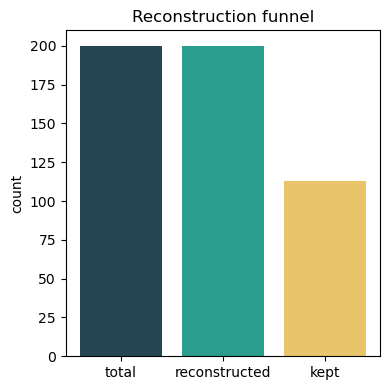

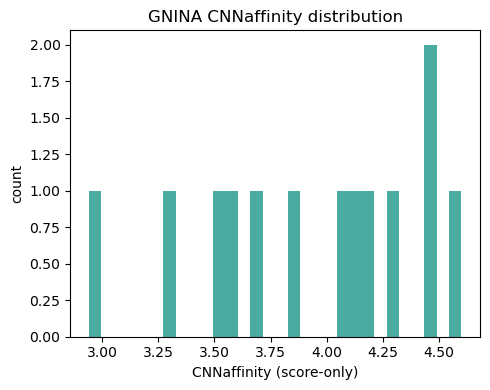

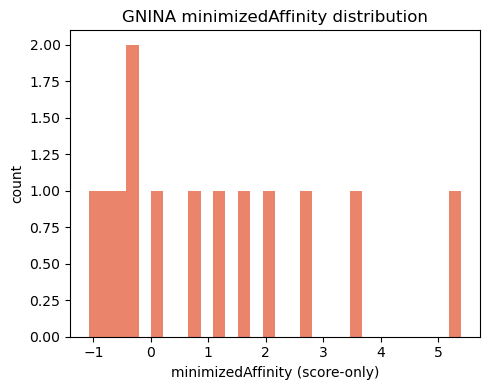

In [27]:
# funnel
labels = ['total', 'reconstructed', 'kept']
values = [SUMMARY.get('total_samples', 0), SUMMARY.get('reconstructed', 0), SUMMARY.get('kept_after_filter', 0)]
plt.figure(figsize=(4, 4))
plt.bar(labels, values, color=['#264653', '#2a9d8f', '#e9c46a'])
plt.ylabel('count')
plt.title('Reconstruction funnel')
plt.tight_layout()
plt.savefig(FIG_DIR / 'reconstruction_funnel.png', dpi=300)
plt.show()

# score distributions
plt.figure(figsize=(5, 4))
plt.hist(pd.to_numeric(score_df['CNNaffinity_score_only'], errors='coerce').dropna(), bins=30, color='#2a9d8f', alpha=0.85)
plt.xlabel('CNNaffinity (score-only)')
plt.ylabel('count')
plt.title('GNINA CNNaffinity distribution')
plt.tight_layout()
plt.savefig(FIG_DIR / 'cnn_affinity_hist.png', dpi=300)
plt.show()

plt.figure(figsize=(5, 4))
plt.hist(pd.to_numeric(score_df['minAff_score_only'], errors='coerce').dropna(), bins=30, color='#e76f51', alpha=0.85)
plt.xlabel('minimizedAffinity (score-only)')
plt.ylabel('count')
plt.title('GNINA minimizedAffinity distribution')
plt.tight_layout()
plt.savefig(FIG_DIR / 'minimized_affinity_hist.png', dpi=300)
plt.show()


## 8) Top-N 排行图（score-only + docking）


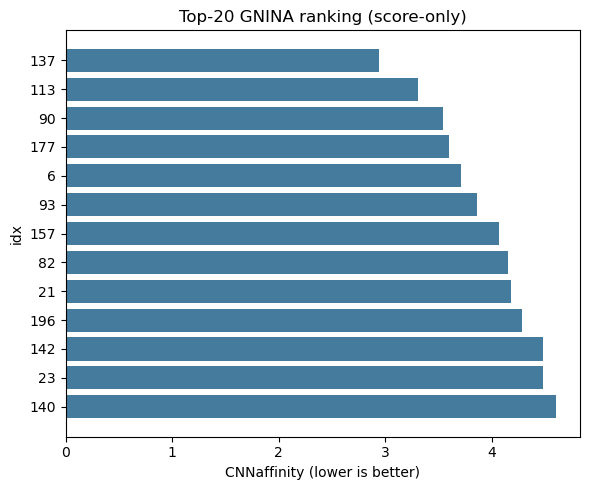

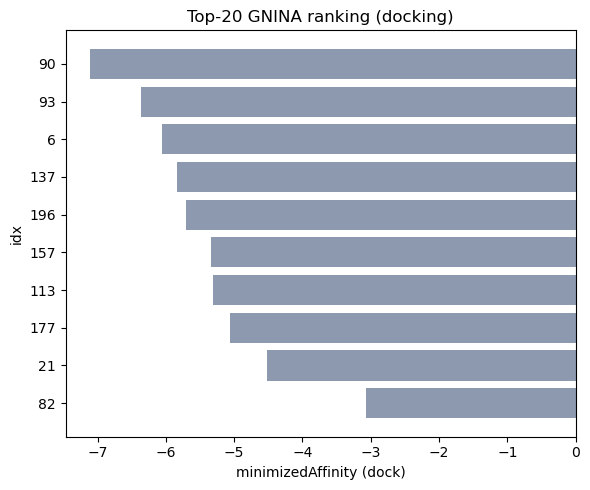

In [28]:
TOP_N_PLOT = 20

plot_df = merged.dropna(subset=['CNNaffinity_score_only']).head(TOP_N_PLOT).copy()
plot_df['idx'] = plot_df['idx'].astype(int).astype(str)

plt.figure(figsize=(6, 5))
plt.barh(plot_df['idx'][::-1], plot_df['CNNaffinity_score_only'][::-1], color='#457b9d')
plt.xlabel('CNNaffinity (lower is better)')
plt.ylabel('idx')
plt.title(f'Top-{TOP_N_PLOT} GNINA ranking (score-only)')
plt.tight_layout()
plt.savefig(FIG_DIR / f'top{TOP_N_PLOT}_cnn_affinity_score_only.png', dpi=300)
plt.show()

if 'minAff_dock' in merged.columns:
    plot_df2 = merged.dropna(subset=['minAff_dock']).sort_values('minAff_dock', ascending=True).head(TOP_N_PLOT).copy()
    plot_df2['idx'] = plot_df2['idx'].astype(int).astype(str)

    plt.figure(figsize=(6, 5))
    plt.barh(plot_df2['idx'][::-1], plot_df2['minAff_dock'][::-1], color='#8d99ae')
    plt.xlabel('minimizedAffinity (dock)')
    plt.ylabel('idx')
    plt.title(f'Top-{TOP_N_PLOT} GNINA ranking (docking)')
    plt.tight_layout()
    plt.savefig(FIG_DIR / f'top{TOP_N_PLOT}_min_aff_dock.png', dpi=300)
    plt.show()


## 9) 2D 分子出图（Top-N 网格 + 单张）


In [29]:
TOP_N_DRAW = 20
best = merged.dropna(subset=['CNNaffinity_score_only']).head(TOP_N_DRAW)
idxs = [int(x) for x in best['idx'].tolist() if pd.notna(x)]

mols = []
legends = []
for idx in idxs:
    sdf = GNINA_DIR / f'mol_{idx}.sdf'
    mol = Chem.SDMolSupplier(str(sdf), removeHs=False, sanitize=False)[0]
    if mol is None:
        continue
    mols.append(Chem.RemoveHs(mol, sanitize=False))
    legends.append(f'{idx}')

from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor

try:
    import cairosvg  # 用于将 RDKit SVG 转成 PNG（即使 RDKit 无 Cairo 也能出 PNG）
    HAS_CAIROSVG = True
except Exception:
    cairosvg = None
    HAS_CAIROSVG = False


def svg_to_png(svg_text: str, out_png, dpi=300) -> bool:
    if not HAS_CAIROSVG:
        return False
    cairosvg.svg2png(bytestring=svg_text.encode('utf-8'), write_to=str(out_png), dpi=dpi)
    return True


def has_rdkit_cairo() -> bool:
    try:
        _ = rdMolDraw2D.MolDraw2DCairo(10, 10)
        return True
    except Exception:
        return False


HAS_CAIRO = has_rdkit_cairo()
if (not HAS_CAIRO) and (not HAS_CAIROSVG):
    print('RDKit Cairo 后端不可用，且未检测到 cairosvg；将仅输出 SVG。')

# --- Grid 图：同时输出 SVG + PNG ---
if mols:
    svg_text = Draw._MolsToGridSVG(mols, molsPerRow=4, subImgSize=(250, 250), legends=legends)
    (FIG_DIR / f'top{TOP_N_DRAW}_mols_grid.svg').write_text(svg_text)

    if HAS_CAIRO:
        png_bytes = Draw._MolsToGridImage(
            mols,
            molsPerRow=4,
            subImgSize=(250, 250),
            legends=legends,
            returnPNG=True,
        )
        (FIG_DIR / f'top{TOP_N_DRAW}_mols_grid.png').write_bytes(png_bytes)
    else:
        _ = svg_to_png(svg_text, FIG_DIR / f'top{TOP_N_DRAW}_mols_grid.png', dpi=300)

# --- 单分子 2D：同时输出 SVG + PNG ---
for idx in idxs:
    sdf = GNINA_DIR / f'mol_{idx}.sdf'
    mol3d = Chem.SDMolSupplier(str(sdf), removeHs=False, sanitize=False)[0]
    if mol3d is None:
        continue

    mol = Chem.RemoveHs(mol3d, sanitize=False)
    mol2d = Chem.Mol(mol)
    try:
        rdDepictor.Compute2DCoords(mol2d)
    except Exception:
        pass

    # SVG（一定可用）
    drawer_svg = rdMolDraw2D.MolDraw2DSVG(350, 350)
    drawer_svg.DrawMolecule(mol2d)
    drawer_svg.FinishDrawing()
    svg_text = drawer_svg.GetDrawingText()
    (FIG_DIR / f'mol_{idx}_2d.svg').write_text(svg_text)

    # PNG
    if HAS_CAIRO:
        drawer_png = rdMolDraw2D.MolDraw2DCairo(350, 350)
        drawer_png.DrawMolecule(mol2d)
        drawer_png.FinishDrawing()
        (FIG_DIR / f'mol_{idx}_2d.png').write_bytes(drawer_png.GetDrawingText())
    else:
        _ = svg_to_png(svg_text, FIG_DIR / f'mol_{idx}_2d.png', dpi=300)

print('saved 2D images ->', FIG_DIR)


[01:12:34] atom 0 has specified valence (1) smaller than the drawn valence 2.
[01:12:34] atom 14 has specified valence (4) smaller than the drawn valence 5.
[01:12:34] atom 0 has specified valence (3) smaller than the drawn valence 4.
[01:12:34] atom 12 has specified valence (4) smaller than the drawn valence 5.
[01:12:34] atom 13 has specified valence (1) smaller than the drawn valence 2.
[01:12:34] atom 17 has specified valence (4) smaller than the drawn valence 5.
[01:12:34] atom 12 has specified valence (3) smaller than the drawn valence 4.
[01:12:34] atom 10 has specified valence (1) smaller than the drawn valence 2.
[01:12:34] atom 11 has specified valence (3) smaller than the drawn valence 4.
[01:12:34] atom 9 has specified valence (3) smaller than the drawn valence 4.
[01:12:34] atom 1 has specified valence (1) smaller than the drawn valence 2.
[01:12:34] atom 8 has specified valence (3) smaller than the drawn valence 4.
[01:12:34] atom 9 has specified valence (1) smaller than 

saved 2D images -> /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/DiffSMol/result_smoke/mapk3_pocket_batch2/gnina_v2/figures


[01:12:34] atom 10 has specified valence (1) smaller than the drawn valence 2.
[01:12:34] atom 11 has specified valence (3) smaller than the drawn valence 4.
[01:12:34] atom 9 has specified valence (3) smaller than the drawn valence 4.
[01:12:34] atom 1 has specified valence (1) smaller than the drawn valence 2.
[01:12:34] atom 8 has specified valence (3) smaller than the drawn valence 4.
[01:12:34] atom 9 has specified valence (1) smaller than the drawn valence 2.
[01:12:34] atom 12 has specified valence (3) smaller than the drawn valence 4.
[01:12:34] atom 17 has specified valence (1) smaller than the drawn valence 2.
[01:12:34] atom 18 has specified valence (3) smaller than the drawn valence 4.
[01:12:34] atom 6 has specified valence (5) smaller than the drawn valence 6.


## 10) 性质-分数关系（散点 + 相关性热图）


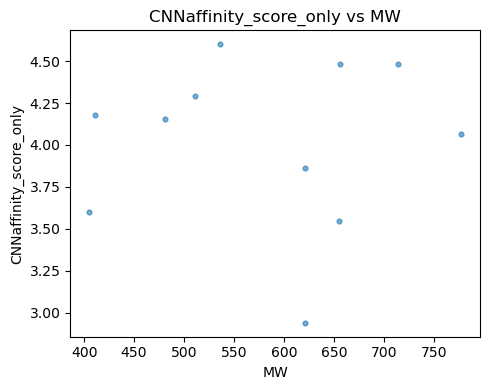

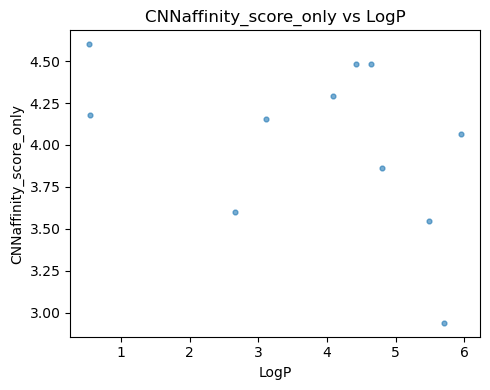

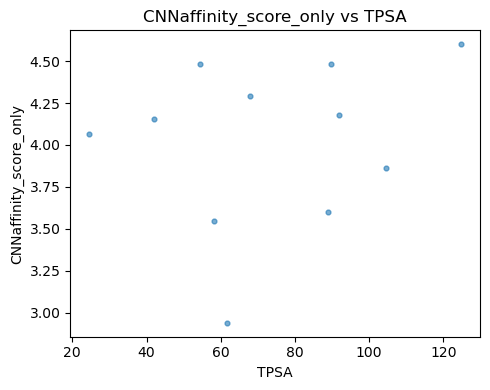

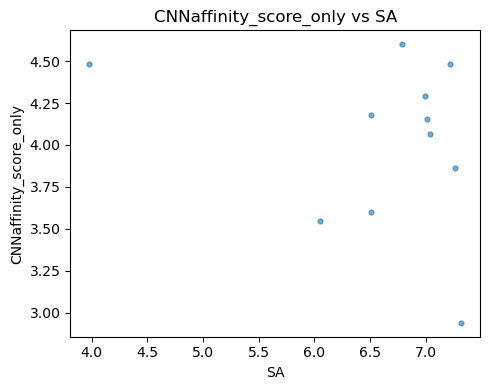

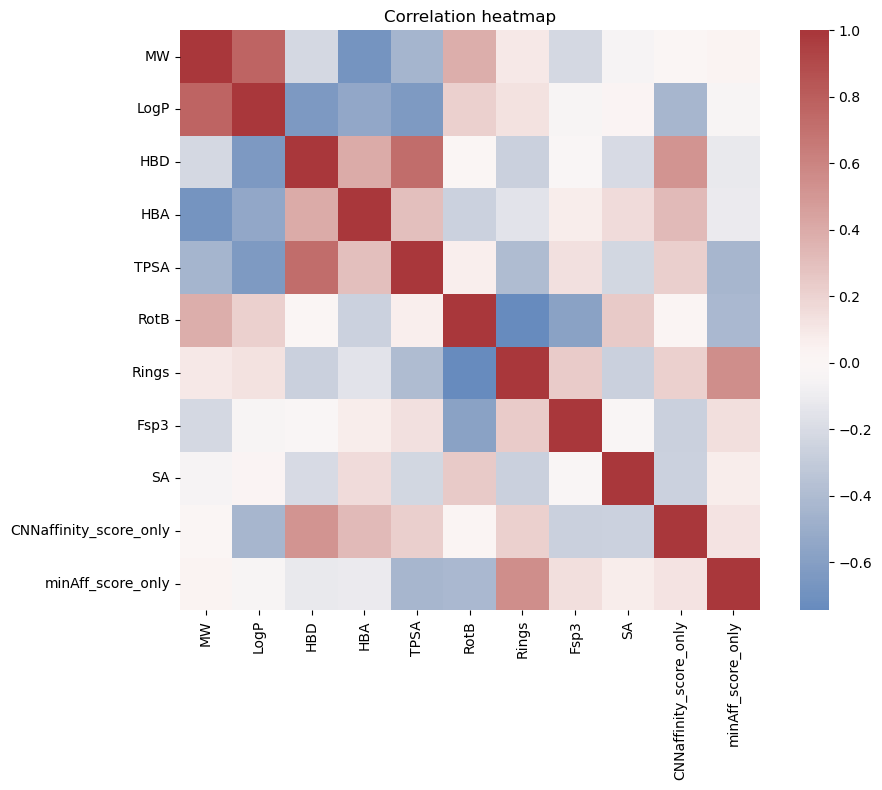

In [30]:
# scatter plots
pairs = [
    ('MW', 'CNNaffinity_score_only'),
    ('LogP', 'CNNaffinity_score_only'),
    ('TPSA', 'CNNaffinity_score_only'),
    ('SA', 'CNNaffinity_score_only'),
]

for x, y in pairs:
    df = merged[[x, y]].copy()
    df[x] = pd.to_numeric(df[x], errors='coerce')
    df[y] = pd.to_numeric(df[y], errors='coerce')
    df = df.dropna()
    if df.empty:
        continue

    plt.figure(figsize=(5, 4))
    plt.scatter(df[x], df[y], s=12, alpha=0.6)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} vs {x}')
    plt.tight_layout()
    plt.savefig(FIG_DIR / f'scatter_{y}_vs_{x}.png', dpi=300)
    plt.show()

# correlation heatmap
cols = ['MW','LogP','HBD','HBA','TPSA','RotB','Rings','Fsp3','SA','CNNaffinity_score_only','minAff_score_only']
corr_df = merged[cols].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), cmap='vlag', center=0, square=True)
plt.title('Correlation heatmap')
plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_heatmap.png', dpi=300)
plt.show()


## 11) Murcko Scaffold 统计


[01:12:35] Explicit valence for atom # 3 P, 6, is greater than permitted
[01:12:35] Explicit valence for atom # 6 P, 6, is greater than permitted


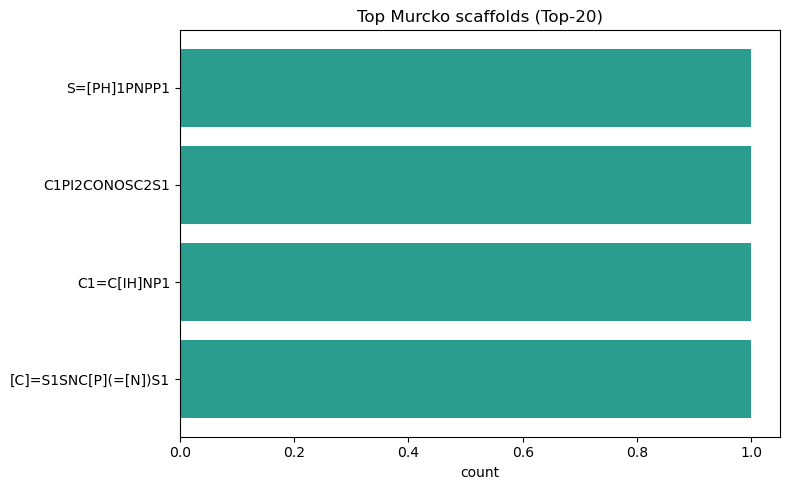

In [31]:
scaffolds = []
for smi in merged['smiles'].fillna(''):
    if not smi:
        scaffolds.append('')
        continue
    m = Chem.MolFromSmiles(smi)
    if m is None:
        scaffolds.append('')
        continue
    sc = MurckoScaffold.MurckoScaffoldSmiles(mol=m)
    scaffolds.append(sc)

merged_sc = merged.copy()
merged_sc['scaffold'] = scaffolds
sc_count = merged_sc[merged_sc['scaffold'] != '']['scaffold'].value_counts().head(20)

plt.figure(figsize=(8, 5))
plt.barh(sc_count.index[::-1], sc_count.values[::-1], color='#2a9d8f')
plt.xlabel('count')
plt.title('Top Murcko scaffolds (Top-20)')
plt.tight_layout()
plt.savefig(FIG_DIR / 'murcko_scaffold_top20.png', dpi=300)
plt.show()


## 12) 化学空间（UMAP）+ Top 分子标注


[01:12:35] atom 0 has specified valence (1) smaller than the drawn valence 2.
[01:12:35] atom 14 has specified valence (4) smaller than the drawn valence 5.
[01:12:35] DEPRECATION WARNING: please use MorganGenerator
[01:12:35] atom 0 has specified valence (3) smaller than the drawn valence 4.
[01:12:35] Explicit valence for atom # 15 P, 6, is greater than permitted
[01:12:35] atom 12 has specified valence (4) smaller than the drawn valence 5.
[01:12:35] atom 13 has specified valence (1) smaller than the drawn valence 2.
[01:12:35] atom 17 has specified valence (4) smaller than the drawn valence 5.
[01:12:35] DEPRECATION WARNING: please use MorganGenerator
[01:12:35] DEPRECATION WARNING: please use MorganGenerator
[01:12:35] atom 12 has specified valence (3) smaller than the drawn valence 4.
[01:12:35] Explicit valence for atom # 9 P, 6, is greater than permitted
[01:12:35] DEPRECATION WARNING: please use MorganGenerator
[01:12:35] DEPRECATION WARNING: please use MorganGenerator
[01:12:

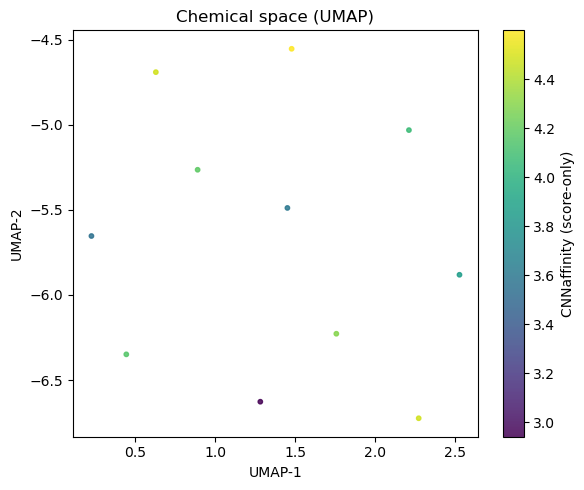

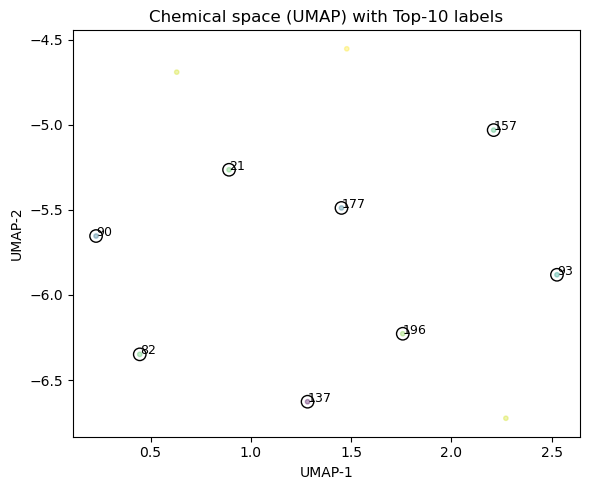

In [32]:
import umap

# 仅使用能算出指纹且有分数的分子
use = merged.dropna(subset=['CNNaffinity_score_only']).copy()


def sanitize_mol_for_fp(mol3d):
    try:
        mol = Chem.RemoveHs(mol3d, sanitize=False)
        mol = Chem.Mol(mol)
        Chem.SanitizeMol(mol, Chem.SANITIZE_ALL ^ Chem.SANITIZE_KEKULIZE)
        return mol
    except Exception:
        return None


fps = []
idxs = []
for idx in use['idx'].astype(int).tolist():
    sdf = GNINA_DIR / f'mol_{idx}.sdf'
    mol3d = Chem.SDMolSupplier(str(sdf), removeHs=False, sanitize=False)[0]
    if mol3d is None:
        continue
    mol = sanitize_mol_for_fp(mol3d)
    if mol is None:
        continue

    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    arr = np.zeros((2048,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    fps.append(arr)
    idxs.append(idx)

X = np.stack(fps, axis=0)

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=0)
Z = reducer.fit_transform(X)

score_map = use.set_index('idx')['CNNaffinity_score_only'].to_dict()
colors = np.array([score_map.get(i, np.nan) for i in idxs], dtype=float)

plt.figure(figsize=(6, 5))
sc = plt.scatter(Z[:, 0], Z[:, 1], c=colors, s=10, cmap='viridis', alpha=0.85)
plt.colorbar(sc, label='CNNaffinity (score-only)')
plt.title('Chemical space (UMAP)')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.tight_layout()
plt.savefig(FIG_DIR / 'umap_chemical_space.png', dpi=300)
plt.show()

# 标注 Top-10
best10 = merged.dropna(subset=['CNNaffinity_score_only']).head(10)['idx'].astype(int).tolist()
idx_to_row = {idx: i for i, idx in enumerate(idxs)}

plt.figure(figsize=(6, 5))
plt.scatter(Z[:, 0], Z[:, 1], c=colors, s=10, cmap='viridis', alpha=0.35)
for idx in best10:
    if idx not in idx_to_row:
        continue
    j = idx_to_row[idx]
    plt.scatter(Z[j, 0], Z[j, 1], s=80, edgecolor='black', facecolor='none')
    plt.text(Z[j, 0], Z[j, 1], str(idx), fontsize=9)
plt.title('Chemical space (UMAP) with Top-10 labels')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.tight_layout()
plt.savefig(FIG_DIR / 'umap_top10_labeled.png', dpi=300)
plt.show()


## 13) Top-N 相似性热图（Tanimoto）


[01:12:35] atom 0 has specified valence (1) smaller than the drawn valence 2.
[01:12:35] atom 14 has specified valence (4) smaller than the drawn valence 5.
[01:12:35] DEPRECATION WARNING: please use MorganGenerator
[01:12:35] atom 0 has specified valence (3) smaller than the drawn valence 4.
[01:12:35] Explicit valence for atom # 15 P, 6, is greater than permitted
[01:12:35] atom 12 has specified valence (4) smaller than the drawn valence 5.
[01:12:35] atom 13 has specified valence (1) smaller than the drawn valence 2.
[01:12:35] atom 17 has specified valence (4) smaller than the drawn valence 5.
[01:12:35] DEPRECATION WARNING: please use MorganGenerator
[01:12:35] DEPRECATION WARNING: please use MorganGenerator
[01:12:35] atom 12 has specified valence (3) smaller than the drawn valence 4.
[01:12:35] Explicit valence for atom # 9 P, 6, is greater than permitted
[01:12:35] DEPRECATION WARNING: please use MorganGenerator
[01:12:35] DEPRECATION WARNING: please use MorganGenerator
[01:12:

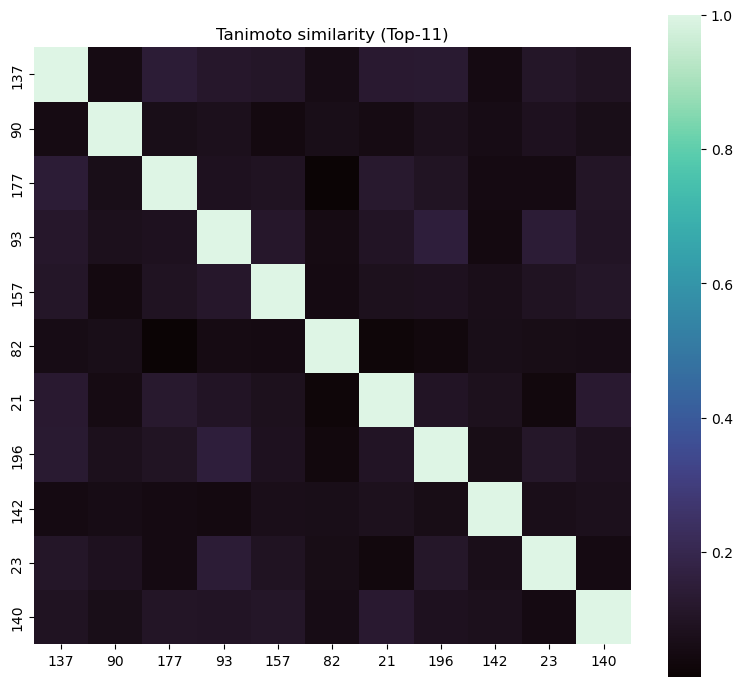

In [33]:
TOP_N_SIM = 30
sel = merged.dropna(subset=['CNNaffinity_score_only']).head(TOP_N_SIM)
sel_idxs = sel['idx'].astype(int).tolist()


def sanitize_mol_for_fp(mol3d):
    try:
        mol = Chem.RemoveHs(mol3d, sanitize=False)
        mol = Chem.Mol(mol)
        Chem.SanitizeMol(mol, Chem.SANITIZE_ALL ^ Chem.SANITIZE_KEKULIZE)
        return mol
    except Exception:
        return None


fps = []
valid_idxs = []
for idx in sel_idxs:
    mol3d = Chem.SDMolSupplier(str(GNINA_DIR / f'mol_{idx}.sdf'), removeHs=False, sanitize=False)[0]
    mol = sanitize_mol_for_fp(mol3d)
    if mol is None:
        continue
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    fps.append(fp)
    valid_idxs.append(idx)

sim = np.zeros((len(fps), len(fps)))
for i in range(len(fps)):
    sim[i, :] = DataStructs.BulkTanimotoSimilarity(fps[i], fps)

plt.figure(figsize=(8, 7))
sns.heatmap(sim, cmap='mako', square=True, xticklabels=valid_idxs, yticklabels=valid_idxs)
plt.title(f'Tanimoto similarity (Top-{len(valid_idxs)})')
plt.tight_layout()
plt.savefig(FIG_DIR / f'tanimoto_top{len(valid_idxs)}.png', dpi=300)
plt.show()


## 14) 口袋接触分布（基于距离阈值的统计）


[01:12:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


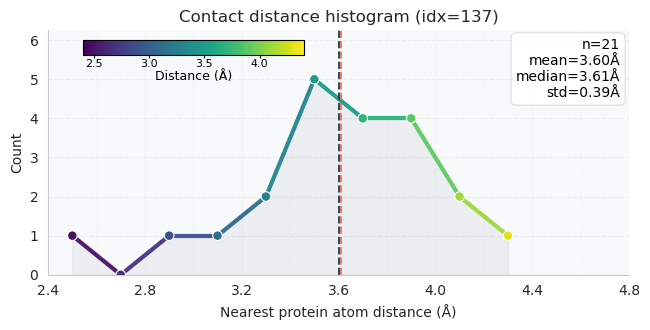

[01:12:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


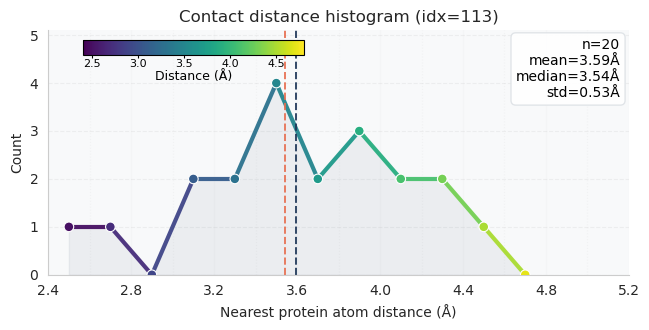

[01:12:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


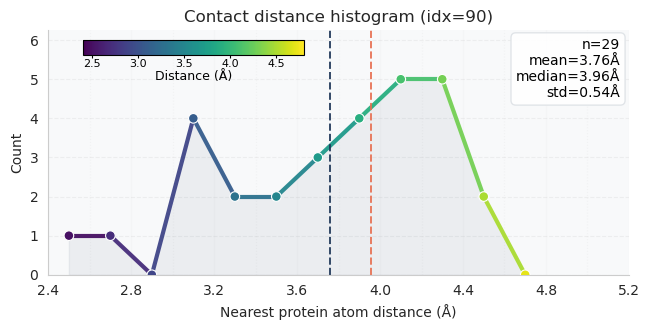

[01:12:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


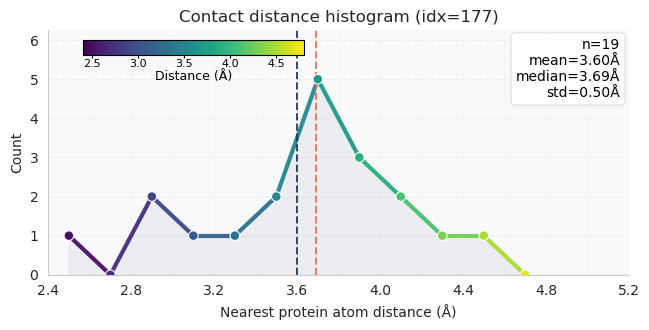

[01:12:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


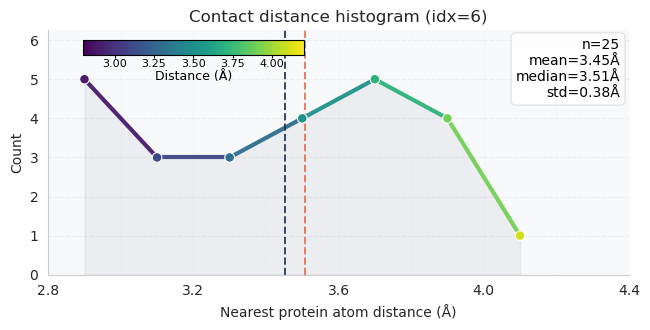

[01:12:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


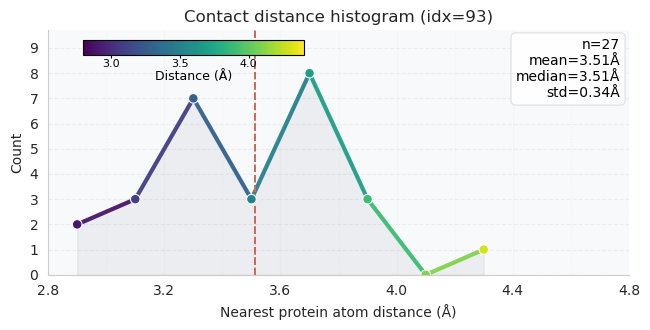

[01:12:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


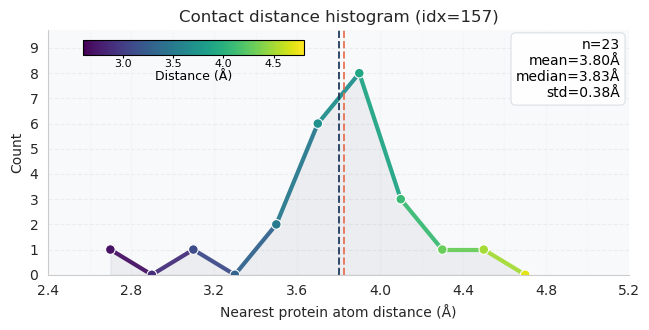

[01:12:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


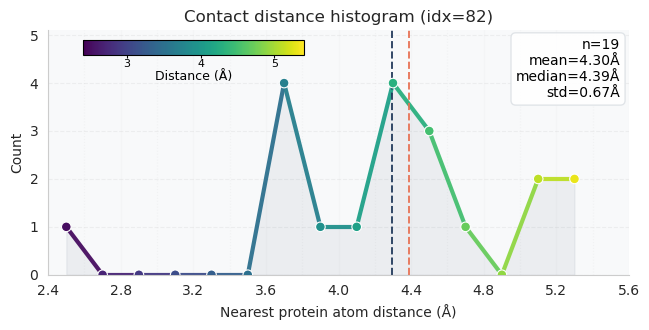

[01:12:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


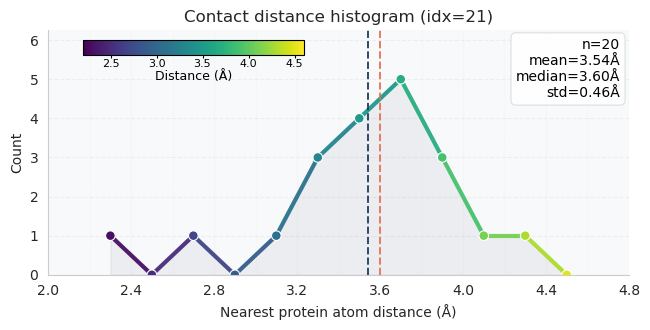

[01:12:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


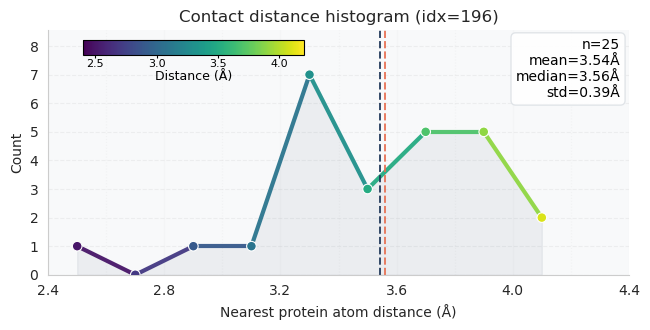

In [34]:
# 解析蛋白 ATOM 坐标
prot_xyz = []
with open(PROTEIN_PDB, 'r') as f:
    for line in f:
        if not line.startswith('ATOM'):
            continue
        x = float(line[30:38]); y = float(line[38:46]); z = float(line[46:54])
        prot_xyz.append([x,y,z])
prot_xyz = np.array(prot_xyz, dtype=float)

from scipy.spatial import cKDTree
prot_tree = cKDTree(prot_xyz)

TOP_CONTACT = 10
sel = merged.dropna(subset=['CNNaffinity_score_only']).head(TOP_CONTACT)
sel_idxs = sel['idx'].astype(int).tolist()

for idx in sel_idxs:
    dock_sdf = GNINA_DIR / f'gnina_docked_{idx}.sdf'
    lig_sdf = dock_sdf if dock_sdf.exists() else (GNINA_DIR / f'mol_{idx}.sdf')
    lig = Chem.SDMolSupplier(str(lig_sdf), removeHs=False, sanitize=False)[0]
    if lig is None:
        continue
    lig_pos = lig.GetConformer().GetPositions()
    dists, _ = prot_tree.query(lig_pos, k=1)

    plot_distance_histogram(
        dists,
        title=f'Contact distance histogram (idx={idx})',
        out_path=FIG_DIR / f'contact_dist_hist_{idx}.png',
        binwidth=0.20,
        cmap='viridis',
        figsize=(6.6, 3.4),
        dpi=300,
        show=True,
    )


## 15) 3D 示意图（matplotlib 版，可稳定保存 PNG）


[01:12:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


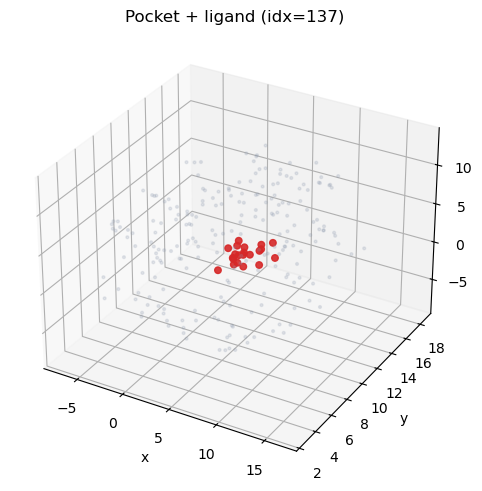

[01:12:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


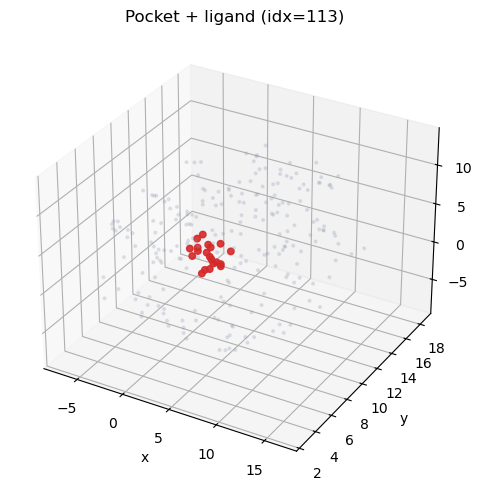

[01:12:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


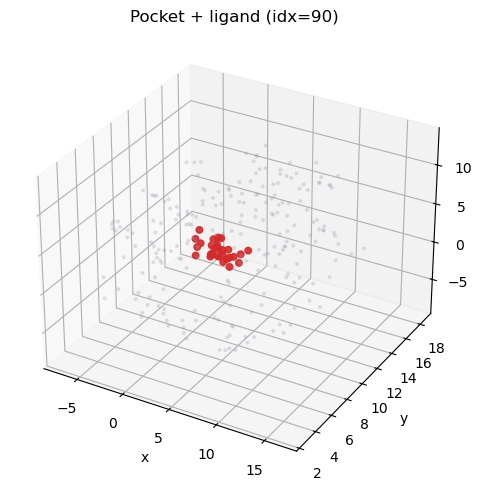

[01:12:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


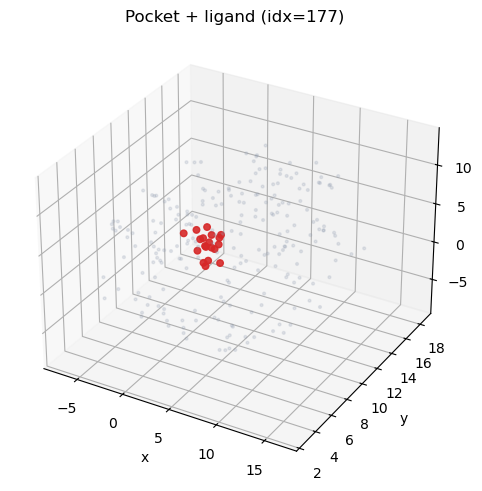

[01:12:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


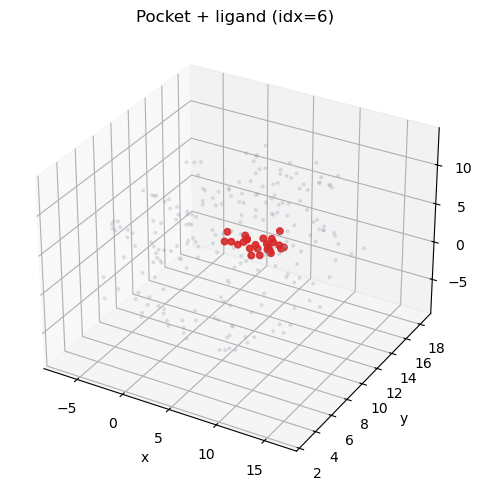

[01:12:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


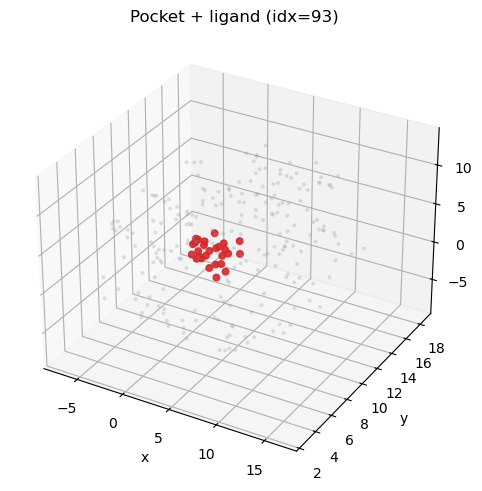

In [35]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# 用参考配体定义口袋（距离阈值）
ref_mol = Chem.SDMolSupplier(str(REF_LIGAND_SDF), removeHs=False, sanitize=False)[0]
ref_pos = ref_mol.GetConformer().GetPositions()

POCKET_RADIUS = 8.0
prot_tree = cKDTree(prot_xyz)
pocket_idx = set()
for p in ref_pos:
    pocket_idx.update(prot_tree.query_ball_point(p, POCKET_RADIUS))
pocket_xyz = prot_xyz[sorted(pocket_idx)]

TOP_3D = 6
sel = merged.dropna(subset=['CNNaffinity_score_only']).head(TOP_3D)
sel_idxs = sel['idx'].astype(int).tolist()

for idx in sel_idxs:
    dock_sdf = GNINA_DIR / f'gnina_docked_{idx}.sdf'
    lig_sdf = dock_sdf if dock_sdf.exists() else (GNINA_DIR / f'mol_{idx}.sdf')
    lig = Chem.SDMolSupplier(str(lig_sdf), removeHs=False, sanitize=False)[0]
    if lig is None:
        continue
    lig_pos = lig.GetConformer().GetPositions()

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pocket_xyz[:, 0], pocket_xyz[:, 1], pocket_xyz[:, 2], s=4, c='#8d99ae', alpha=0.20)
    ax.scatter(lig_pos[:, 0], lig_pos[:, 1], lig_pos[:, 2], s=22, c='#d62828', alpha=0.90)
    ax.set_title(f'Pocket + ligand (idx={idx})')
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
    plt.tight_layout()
    fig.savefig(FIG_DIR / f'pocket_ligand_3d_{idx}.png', dpi=300)
    plt.show()


## 16) py3Dmol 交互式三维可视化与相互作用统计

基于配体-蛋白原子距离阈值进行接触/相互作用统计，并在 3D 视图中高亮关键口袋残基与近距离接触连线。


In [36]:
import py3Dmol
from IPython.display import display
from scipy.spatial import cKDTree

IDX_3DMOL = int(merged.dropna(subset=['CNNaffinity_score_only']).head(1)['idx'].iloc[0])
CONTACT_CUTOFF_A = 4.0
TOP_RESIDUES = 25
TOP_LINES = 30
SHOW_POCKET_SURFACE = True
SURFACE_OPACITY = 0.25


def load_pdb_atoms(pdb_path: Path) -> pd.DataFrame:
    rows = []
    with open(pdb_path, 'r') as f:
        for line in f:
            record = line[0:6].strip()
            if record != 'ATOM':
                continue
            resname = line[17:20].strip()
            if resname in {'HOH', 'WAT'}:
                continue

            atom_name = line[12:16].strip()
            chain = line[21].strip()
            try:
                resseq = int(line[22:26])
            except ValueError:
                continue
            try:
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
            except ValueError:
                continue

            element = line[76:78].strip().upper()
            if not element:
                element = ''.join([c for c in atom_name if c.isalpha()])[:1].upper()
            if element == 'H':
                continue

            rows.append({
                'atom_name': atom_name,
                'resname': resname,
                'chain': chain,
                'resseq': resseq,
                'x': x,
                'y': y,
                'z': z,
                'element': element,
            })

    return pd.DataFrame(rows)


def best_pose_from_sdf(sdf_path: Path):
    mols = [m for m in Chem.SDMolSupplier(str(sdf_path), removeHs=False, sanitize=False) if m is not None]
    if not mols:
        return None
    if len(mols) == 1:
        return mols[0]

    def prop(m, name: str):
        if not m.HasProp(name):
            return np.nan
        try:
            return float(m.GetProp(name))
        except Exception:
            return np.nan

    for key in ['minimizedAffinity', 'CNNaffinity']:
        vals = np.array([prop(m, key) for m in mols], dtype=float)
        if np.isfinite(vals).any():
            return mols[int(np.nanargmin(vals))]
    return mols[0]


def residue_class(resname: str) -> str:
    hydrophobic = {'ALA', 'VAL', 'LEU', 'ILE', 'PRO', 'MET'}
    aromatic = {'PHE', 'TRP', 'TYR'}
    polar = {'SER', 'THR', 'ASN', 'GLN', 'CYS'}
    positive = {'LYS', 'ARG', 'HIS'}
    negative = {'ASP', 'GLU'}

    if resname in hydrophobic:
        return 'hydrophobic'
    if resname in aromatic:
        return 'aromatic'
    if resname in polar:
        return 'polar'
    if resname in positive:
        return 'positive'
    if resname in negative:
        return 'negative'
    if resname == 'GLY':
        return 'gly'
    return 'other'


dock_sdf = GNINA_DIR / f'gnina_docked_{IDX_3DMOL}.sdf'
lig_sdf = dock_sdf if dock_sdf.exists() else (GNINA_DIR / f'mol_{IDX_3DMOL}.sdf')
lig = best_pose_from_sdf(lig_sdf)
if lig is None:
    raise RuntimeError(f'Failed to load ligand: {lig_sdf}')

prot_atoms = load_pdb_atoms(PROTEIN_PDB)
if prot_atoms.empty:
    raise RuntimeError(f'No ATOM records parsed from: {PROTEIN_PDB}')

lig_heavy = Chem.RemoveHs(lig, sanitize=False)
lig_coords = np.asarray(lig_heavy.GetConformer().GetPositions(), dtype=float)
lig_elems = np.array([a.GetSymbol().upper() for a in lig_heavy.GetAtoms()], dtype=object)

tree = cKDTree(lig_coords)
prot_coords = prot_atoms[['x', 'y', 'z']].to_numpy(dtype=float)
dists, nn = tree.query(prot_coords, k=1)

prot_atoms = prot_atoms.copy()
prot_atoms['min_dist_to_lig'] = dists
prot_atoms['nn_lig_atom'] = nn
prot_atoms['nn_lig_elem'] = lig_elems[nn]

polar_like = {'N', 'O', 'S', 'F', 'CL', 'BR', 'I', 'P'}
prot_atoms['contact_type'] = np.where(
    (prot_atoms['element'].isin(polar_like)) & (prot_atoms['nn_lig_elem'].isin(polar_like)),
    'polar',
    'hydrophobic',
)

contact_atoms = prot_atoms[prot_atoms['min_dist_to_lig'] <= CONTACT_CUTOFF_A].copy()
res_stats = (
    contact_atoms.groupby(['chain', 'resname', 'resseq'])
    .agg(
        n_atoms=('atom_name', 'count'),
        min_dist=('min_dist_to_lig', 'min'),
        mean_dist=('min_dist_to_lig', 'mean'),
        n_polar=('contact_type', lambda s: int((s == 'polar').sum())),
        n_hydrophobic=('contact_type', lambda s: int((s == 'hydrophobic').sum())),
    )
    .reset_index()
    .sort_values(['n_atoms', 'min_dist'], ascending=[False, True])
)
res_stats['label'] = res_stats.apply(
    lambda r: '{}{}({})'.format(r['resname'], int(r['resseq']), r['chain'] if r['chain'] else '-'),
    axis=1,
)
res_stats['class'] = res_stats['resname'].map(residue_class)

out_csv = FIG_DIR / f'interactions_idx{IDX_3DMOL}_residue_contacts.csv'
res_stats.to_csv(out_csv, index=False)

print(f'IDX_3DMOL={IDX_3DMOL}  ligand={lig_sdf.name}')
print(f'Contact cutoff: {CONTACT_CUTOFF_A:.1f} Å')
print(f'Contact residues: {len(res_stats)}  Contact atoms: {len(contact_atoms)}')
print('Saved:', out_csv)
display(res_stats.head(20))

# --- Plots (export PNG) ---
top = res_stats.head(TOP_RESIDUES).sort_values('n_atoms', ascending=True)

plt.figure(figsize=(9, 6))
plt.barh(top['label'], top['n_atoms'], color='#457b9d')
plt.xlabel('Contact atom count')
plt.title(f'Residue contacts (Top-{len(top)})')
plt.tight_layout()
plt.savefig(FIG_DIR / f'interactions_idx{IDX_3DMOL}_residue_contacts_top{len(top)}.png', dpi=300)
plt.show()

plt.figure(figsize=(9, 6))
plt.barh(top['label'], top['n_hydrophobic'], color='#adb5bd', label='hydrophobic')
plt.barh(top['label'], top['n_polar'], left=top['n_hydrophobic'], color='#00b4d8', label='polar')
plt.xlabel('Contact atom count')
plt.title(f'Contact atom types (Top-{len(top)})')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(FIG_DIR / f'interactions_idx{IDX_3DMOL}_contact_types_top{len(top)}.png', dpi=300)
plt.show()

plt.figure(figsize=(9, 6))
plt.barh(top['label'], top['min_dist'], color='#2a9d8f')
plt.xlabel('Min distance to ligand (Å)')
plt.title(f'Residue min distance (Top-{len(top)})')
plt.tight_layout()
plt.savefig(FIG_DIR / f'interactions_idx{IDX_3DMOL}_residue_min_dist_top{len(top)}.png', dpi=300)
plt.show()

class_df = (
    res_stats.groupby('class')
    .agg(n_res=('label', 'count'), n_atoms=('n_atoms', 'sum'))
    .reset_index()
    .sort_values('n_atoms', ascending=False)
)
plt.figure(figsize=(6, 4))
plt.bar(class_df['class'], class_df['n_atoms'], color='#e76f51')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Contact atom count')
plt.title('Contact composition by residue class')
plt.tight_layout()
plt.savefig(FIG_DIR / f'interactions_idx{IDX_3DMOL}_class_contact_atoms.png', dpi=300)
plt.show()

plot_distance_histogram(
    contact_atoms['min_dist_to_lig'],
    title='Contact atom distance distribution',
    out_path=FIG_DIR / f'interactions_idx{IDX_3DMOL}_contact_atom_dist_hist.png',
    binwidth=0.20,
    cmap='viridis',
    figsize=(6.6, 3.4),
    dpi=300,
    show=True,
)

# --- py3Dmol (interactive) ---
pdb_text = Path(PROTEIN_PDB).read_text()

v = py3Dmol.view(width=980, height=620)
v.addModel(pdb_text, 'pdb')
v.setStyle({'cartoon': {'color': 'spectrum'}})

v.addModel(Chem.MolToMolBlock(lig), 'sdf')
v.setStyle({'model': 1}, {'stick': {'colorscheme': 'cyanCarbon'}})

highlight = res_stats.head(max(TOP_RESIDUES, 1))
for r in highlight.itertuples(index=False):
    sel = {'resi': int(r.resseq)}
    if getattr(r, 'chain', ''):
        sel['chain'] = r.chain
    v.addStyle(sel, {'stick': {'color': '#f4a261'}})

if SHOW_POCKET_SURFACE and len(highlight) > 0:
    for chain, group in highlight.groupby('chain'):
        resis = [int(x) for x in group['resseq'].tolist()]
        sel = {'resi': resis}
        if chain:
            sel['chain'] = chain
        v.addSurface(py3Dmol.VDW, {'opacity': SURFACE_OPACITY, 'color': 'white'}, sel)

pairs = contact_atoms.sort_values('min_dist_to_lig', ascending=True).head(TOP_LINES)
for r in pairs.itertuples(index=False):
    start = {'x': float(r.x), 'y': float(r.y), 'z': float(r.z)}
    end = {
        'x': float(lig_coords[int(r.nn_lig_atom), 0]),
        'y': float(lig_coords[int(r.nn_lig_atom), 1]),
        'z': float(lig_coords[int(r.nn_lig_atom), 2]),
    }
    color = '#00b4d8' if r.contact_type == 'polar' else '#adb5bd'
    v.addLine({'start': start, 'end': end, 'dashed': True, 'color': color, 'opacity': 0.85})

label_res = res_stats.head(10)
for rr in label_res.itertuples(index=False):
    mask = (
        (prot_atoms['resname'] == rr.resname)
        & (prot_atoms['resseq'] == rr.resseq)
        & (prot_atoms['atom_name'] == 'CA')
    )
    if getattr(rr, 'chain', ''):
        mask = mask & (prot_atoms['chain'] == rr.chain)
    ca = prot_atoms[mask].head(1)
    if ca.empty:
        continue
    pos = {'x': float(ca['x'].iloc[0]), 'y': float(ca['y'].iloc[0]), 'z': float(ca['z'].iloc[0])}
    v.addLabel(
        f'{rr.resname}{int(rr.resseq)}',
        {
            'position': pos,
            'fontSize': 12,
            'backgroundColor': 'white',
            'backgroundOpacity': 0.6,
        },
    )

v.zoomTo()
v.show()

import ipywidgets as widgets
from IPython.display import clear_output

pdb_text = Path(PROTEIN_PDB).read_text()
PROT_ATOMS_TEMPLATE = load_pdb_atoms(PROTEIN_PDB)
PROT_COORDS = PROT_ATOMS_TEMPLATE[['x', 'y', 'z']].to_numpy(dtype=float)
POLAR_LIKE = {'N', 'O', 'S', 'F', 'CL', 'BR', 'I', 'P'}
INTERACTION_COLORS = {
    'hydrophobic': '#adb5bd',
    'polar': '#00b4d8',
    'hbond_like': '#2a9d8f',
    'halogen_like': '#ffb703',
    'aromatic_like': '#b5179e',
}
INTERACTION_LABELS = {
    'hydrophobic': 'Hydrophobic',
    'polar': 'Polar',
    'hbond_like': 'H-bond-like',
    'halogen_like': 'Halogen-like',
    'aromatic_like': 'Aromatic-like',
}
INTERACTION_ORDER = ['hydrophobic', 'polar', 'hbond_like', 'halogen_like', 'aromatic_like']
CURRENT_STATE = {'idx': None, 'pose_source': None}
CURRENT_LIG_SDF = None
CURRENT_VIEW = None
BASE_PROT_ATOMS = None
lig = None
lig_coords = None


def _compute_ligand_aromatic_indices(mol3d) -> set:
    mol = Chem.RemoveHs(mol3d, sanitize=False)
    try:
        m = Chem.Mol(mol)
        Chem.SanitizeMol(m, Chem.SANITIZE_ALL ^ Chem.SANITIZE_KEKULIZE)
        return {a.GetIdx() for a in m.GetAtoms() if a.GetIsAromatic()}
    except Exception:
        return set()


def _select_ligand_sdf(idx: int, pose_source: str) -> Path:
    dock_sdf = GNINA_DIR / f'gnina_docked_{idx}.sdf'
    rec_sdf = GNINA_DIR / f'mol_{idx}.sdf'
    if pose_source == 'docking':
        sdf_path = dock_sdf
    elif pose_source == 'reconstructed':
        sdf_path = rec_sdf
    else:
        sdf_path = dock_sdf if dock_sdf.exists() else rec_sdf
    return sdf_path


def _set_current_compound(idx: int, pose_source: str) -> None:
    global IDX_3DMOL, lig, lig_coords, BASE_PROT_ATOMS, CURRENT_LIG_SDF
    if idx is None:
        raise ValueError('idx is None')
    if CURRENT_STATE.get('idx') == int(idx) and CURRENT_STATE.get('pose_source') == str(pose_source):
        return

    sdf_path = _select_ligand_sdf(int(idx), str(pose_source))
    if not sdf_path.exists():
        raise FileNotFoundError(str(sdf_path))

    mol3d = best_pose_from_sdf(sdf_path)
    if mol3d is None:
        raise RuntimeError(f'Failed to load ligand from {sdf_path}')

    lig = Chem.RemoveHs(mol3d, sanitize=False)
    lig_coords = np.asarray(lig.GetConformer().GetPositions(), dtype=float)
    lig_elems = np.array([a.GetSymbol().upper() for a in lig.GetAtoms()], dtype=object)

    tree = cKDTree(lig_coords)
    dists, nn = tree.query(PROT_COORDS, k=1)

    BASE_PROT_ATOMS = PROT_ATOMS_TEMPLATE.copy()
    BASE_PROT_ATOMS['min_dist_to_lig'] = dists
    BASE_PROT_ATOMS['nn_lig_atom'] = nn
    BASE_PROT_ATOMS['nn_lig_elem'] = lig_elems[nn]
    BASE_PROT_ATOMS['contact_type'] = np.where(
        (BASE_PROT_ATOMS['element'].isin(POLAR_LIKE)) & (BASE_PROT_ATOMS['nn_lig_elem'].isin(POLAR_LIKE)),
        'polar',
        'hydrophobic',
    )
    lig_aromatic = _compute_ligand_aromatic_indices(lig)
    BASE_PROT_ATOMS['nn_lig_aromatic'] = BASE_PROT_ATOMS['nn_lig_atom'].isin(lig_aromatic)
    BASE_PROT_ATOMS['prot_aromatic_res'] = BASE_PROT_ATOMS['resname'].isin({'PHE', 'TYR', 'TRP', 'HIS'})

    CURRENT_STATE['idx'] = int(idx)
    CURRENT_STATE['pose_source'] = str(pose_source)
    CURRENT_LIG_SDF = sdf_path
    IDX_3DMOL = int(idx)


def _filter_contact_atoms(mode: str, cutoff_a: float) -> pd.DataFrame:
    df = BASE_PROT_ATOMS.copy()
    m = df[df['min_dist_to_lig'] <= float(cutoff_a)].copy()
    if m.empty:
        m['interaction_kind'] = pd.Series(dtype='object')
        return m

    thr_hbond = min(float(cutoff_a), 3.5)
    thr_halogen = min(float(cutoff_a), 3.6)

    is_aromatic = (m['prot_aromatic_res']) & (m['nn_lig_aromatic'])
    is_halogen = (
        (m['min_dist_to_lig'] <= thr_halogen)
        & (m['element'].isin({'N', 'O', 'S'}))
        & (m['nn_lig_elem'].isin({'F', 'CL', 'BR', 'I'}))
    )
    is_hbond = (
        (m['min_dist_to_lig'] <= thr_hbond)
        & (m['element'].isin({'N', 'O', 'S'}))
        & (m['nn_lig_elem'].isin({'N', 'O', 'S'}))
    )

    m['interaction_kind'] = m['contact_type'].astype(str)
    m.loc[is_hbond, 'interaction_kind'] = 'hbond_like'
    m.loc[is_halogen, 'interaction_kind'] = 'halogen_like'
    m.loc[is_aromatic, 'interaction_kind'] = 'aromatic_like'
    m.loc[is_aromatic, 'contact_type'] = 'aromatic'

    if mode == 'all':
        return m
    if mode == 'aromatic_like':
        return m[m['interaction_kind'] == 'aromatic_like'].copy()
    if mode == 'hbond_like':
        return m[m['interaction_kind'] == 'hbond_like'].copy()
    if mode == 'halogen_like':
        return m[m['interaction_kind'] == 'halogen_like'].copy()
    if mode == 'polar':
        return m[m['contact_type'] == 'polar'].copy()
    if mode == 'hydrophobic':
        return m[m['contact_type'] == 'hydrophobic'].copy()
    return m


def _residue_contacts(contact_atoms: pd.DataFrame) -> pd.DataFrame:
    if contact_atoms.empty:
        return pd.DataFrame(
            columns=[
                'chain',
                'resname',
                'resseq',
                'n_atoms',
                'min_dist',
                'mean_dist',
                'n_hydrophobic',
                'n_polar',
                'n_hbond_like',
                'n_halogen_like',
                'n_aromatic_like',
                'label',
                'class',
            ]
        )

    res_stats = (
        contact_atoms.groupby(['chain', 'resname', 'resseq'])
        .agg(
            n_atoms=('atom_name', 'count'),
            min_dist=('min_dist_to_lig', 'min'),
            mean_dist=('min_dist_to_lig', 'mean'),
            n_hydrophobic=('interaction_kind', lambda s: int((s == 'hydrophobic').sum())),
            n_polar=('interaction_kind', lambda s: int((s == 'polar').sum())),
            n_hbond_like=('interaction_kind', lambda s: int((s == 'hbond_like').sum())),
            n_halogen_like=('interaction_kind', lambda s: int((s == 'halogen_like').sum())),
            n_aromatic_like=('interaction_kind', lambda s: int((s == 'aromatic_like').sum())),
        )
        .reset_index()
        .sort_values(['n_atoms', 'min_dist'], ascending=[False, True])
    )
    res_stats['label'] = res_stats.apply(
        lambda r: '{}{}({})'.format(r['resname'], int(r['resseq']), r['chain'] if r['chain'] else '-'),
        axis=1,
    )
    res_stats['class'] = res_stats['resname'].map(residue_class)
    return res_stats


def _protein_style(rep: str):
    if rep == 'cartoon_gray':
        return {'cartoon': {'color': 'white'}}
    if rep == 'line':
        return {'line': {'color': 'white'}}
    if rep == 'stick':
        return {'stick': {'color': 'white'}}
    return {'cartoon': {'color': 'spectrum'}}


def _ligand_style(rep: str):
    if rep == 'sphere':
        return {'sphere': {'scale': 0.3, 'color': 'cyan'}}
    if rep == 'stick_sphere':
        return {'stick': {'colorscheme': 'cyanCarbon'}, 'sphere': {'scale': 0.25, 'color': 'cyan'}}
    return {'stick': {'colorscheme': 'cyanCarbon'}}


def _contact_line_color(row, mode: str) -> str:
    kind = getattr(row, 'interaction_kind', None)
    if isinstance(kind, str) and kind in INTERACTION_COLORS:
        return INTERACTION_COLORS[kind]
    if mode in INTERACTION_COLORS:
        return INTERACTION_COLORS[mode]
    if getattr(row, 'contact_type', '') == 'polar':
        return INTERACTION_COLORS['polar']
    return INTERACTION_COLORS['hydrophobic']


def _add_dashed_cylinder(
    v,
    start: dict,
    end: dict,
    radius: float,
    color: str,
    opacity: float,
    dash_len: float = 0.45,
    gap_len: float = 0.25,
    max_segments: int = 60,
) -> None:
    s = np.array([float(start['x']), float(start['y']), float(start['z'])], dtype=float)
    e = np.array([float(end['x']), float(end['y']), float(end['z'])], dtype=float)
    vec = e - s
    dist = float(np.linalg.norm(vec))
    if not np.isfinite(dist) or dist < 1e-6:
        return
    direction = vec / dist

    step = max(float(dash_len) + float(gap_len), 1e-6)
    n = int(np.ceil(dist / step))
    if n > int(max_segments):
        dash_len = dist / (float(max_segments) * 1.5)
        gap_len = dash_len * 0.5
        step = max(float(dash_len) + float(gap_len), 1e-6)

    pos = 0.0
    while pos < dist:
        seg_start = s + direction * pos
        seg_end = s + direction * min(pos + float(dash_len), dist)
        v.addCylinder(
            {
                'start': {'x': float(seg_start[0]), 'y': float(seg_start[1]), 'z': float(seg_start[2])},
                'end': {'x': float(seg_end[0]), 'y': float(seg_end[1]), 'z': float(seg_end[2])},
                'radius': float(radius),
                'fromCap': 1,
                'toCap': 1,
                'color': str(color),
                'opacity': float(opacity),
            }
        )
        pos += step


def _build_view(
    protein_rep: str,
    ligand_rep: str,
    contact_atoms: pd.DataFrame,
    res_stats: pd.DataFrame,
    show_lines: bool,
    line_style: str,
    line_radius: float,
    line_opacity: float,
    show_labels: bool,
    label_size: int,
    show_pocket_surface: bool,
    surface_opacity: float,
    top_residues: int,
    top_lines: int,
    mode: str,
):
    v = py3Dmol.view(width=980, height=620)
    v.setBackgroundColor('white')
    v.addModel(pdb_text, 'pdb')
    v.setStyle(_protein_style(protein_rep))

    v.addModel(Chem.MolToMolBlock(lig), 'sdf')
    v.setStyle({'model': 1}, _ligand_style(ligand_rep))

    highlight = res_stats.head(max(int(top_residues), 1))
    for r in highlight.itertuples(index=False):
        sel = {'resi': int(r.resseq)}
        if getattr(r, 'chain', ''):
            sel['chain'] = r.chain
        v.addStyle(sel, {'stick': {'color': '#f4a261'}})

    if show_pocket_surface and len(highlight) > 0:
        for chain, group in highlight.groupby('chain'):
            resis = [int(x) for x in group['resseq'].tolist()]
            sel = {'resi': resis}
            if chain:
                sel['chain'] = chain
            v.addSurface(py3Dmol.VDW, {'opacity': float(surface_opacity), 'color': 'white'}, sel)

    if show_lines and (not contact_atoms.empty) and int(top_lines) > 0:
        pairs = contact_atoms.sort_values('min_dist_to_lig', ascending=True).head(int(top_lines))
        for r in pairs.itertuples(index=False):
            start = {'x': float(r.x), 'y': float(r.y), 'z': float(r.z)}
            end = {
                'x': float(lig_coords[int(r.nn_lig_atom), 0]),
                'y': float(lig_coords[int(r.nn_lig_atom), 1]),
                'z': float(lig_coords[int(r.nn_lig_atom), 2]),
            }
            color = _contact_line_color(r, mode)
            if line_style == 'cylinder':
                v.addCylinder(
                    {
                        'start': start,
                        'end': end,
                        'radius': float(line_radius),
                        'fromCap': 1,
                        'toCap': 1,
                        'color': color,
                        'opacity': float(line_opacity),
                    }
                )
            elif line_style == 'dashed_cylinder':
                _add_dashed_cylinder(
                    v=v,
                    start=start,
                    end=end,
                    radius=float(line_radius),
                    color=color,
                    opacity=float(line_opacity),
                )
            else:
                v.addLine(
                    {
                        'start': start,
                        'end': end,
                        'dashed': bool(line_style == 'dashed'),
                        'color': color,
                        'opacity': float(line_opacity),
                    }
                )

    if show_labels and (not res_stats.empty):
        label_res = res_stats.head(min(10, len(res_stats)))
        for rr in label_res.itertuples(index=False):
            mask = (
                (BASE_PROT_ATOMS['atom_name'] == 'CA')
                & (BASE_PROT_ATOMS['resname'] == rr.resname)
                & (BASE_PROT_ATOMS['resseq'] == rr.resseq)
            )
            if getattr(rr, 'chain', ''):
                mask = mask & (BASE_PROT_ATOMS['chain'] == rr.chain)
            ca = BASE_PROT_ATOMS[mask].head(1)
            if ca.empty:
                continue
            pos = {'x': float(ca['x'].iloc[0]), 'y': float(ca['y'].iloc[0]), 'z': float(ca['z'].iloc[0])}
            v.addLabel(
                f'{rr.resname}{int(rr.resseq)}',
                {
                    'position': pos,
                    'fontSize': int(label_size),
                    'backgroundColor': 'white',
                    'backgroundOpacity': 0.6,
                },
            )

    v.zoomTo()
    return v


rank_df = score_df.copy()
rank_df['idx'] = pd.to_numeric(rank_df['idx'], errors='coerce')
rank_df = rank_df.dropna(subset=['idx']).copy()
rank_df['idx'] = rank_df['idx'].astype(int)

dock_cols = [c for c in ['minAff_dock', 'CNNaffinity_dock', 'CNNscore_dock'] if c in dock_df.columns]
if dock_cols:
    tmp = dock_df[['idx', *dock_cols]].copy()
    tmp['idx'] = pd.to_numeric(tmp['idx'], errors='coerce')
    tmp = tmp.dropna(subset=['idx']).copy()
    tmp['idx'] = tmp['idx'].astype(int)
    rank_df = rank_df.merge(tmp, on='idx', how='left')

metric_candidates = [
    ('Score-only CNNaffinity', 'CNNaffinity_score_only'),
    ('Score-only minimizedAffinity', 'minAff_score_only'),
    ('Docking minimizedAffinity', 'minAff_dock'),
    ('Docking CNNaffinity', 'CNNaffinity_dock'),
]

metric_options = []
for label, col in metric_candidates:
    if col not in rank_df.columns:
        continue
    if pd.to_numeric(rank_df[col], errors='coerce').notna().any():
        metric_options.append((label, col))

if not metric_options:
    raise RuntimeError('No ranking metrics available in score_df/dock_df')

rank_metric_w = widgets.Dropdown(options=metric_options, value=metric_options[0][1], description='排序指标')
topn_w = widgets.IntSlider(value=min(50, len(rank_df)), min=1, max=min(500, len(rank_df)), step=1, description='候选数', continuous_update=False)
idx_w = widgets.Dropdown(description='化合物', options=[])
pose_source_w = widgets.Dropdown(options=[('Auto', 'auto'), ('Docking', 'docking'), ('Reconstructed', 'reconstructed')], value='auto', description='构象来源')
UPDATING_OPTIONS = False


def _make_idx_options(metric: str, n: int):
    df = rank_df.copy()
    df[metric] = pd.to_numeric(df[metric], errors='coerce')
    df = df.dropna(subset=[metric]).sort_values(metric, ascending=True).head(int(n))
    options = []
    for _, r in df.iterrows():
        idx = int(r['idx'])
        score = float(r[metric])
        label = f"{idx:4d} | {metric}={score:.3f}"
        dock_val = r.get('minAff_dock', np.nan)
        if pd.notna(dock_val):
            try:
                label += f" | minAff_dock={float(dock_val):.2f}"
            except Exception:
                pass
        options.append((label, idx))
    return options


def _refresh_idx_options() -> None:
    global UPDATING_OPTIONS
    UPDATING_OPTIONS = True
    try:
        opts = _make_idx_options(rank_metric_w.value, int(topn_w.value))
        prev = idx_w.value if idx_w.value is not None else None
        idx_w.options = opts
        values = [v for _, v in opts]
        if prev in values:
            idx_w.value = prev
        elif values:
            idx_w.value = values[0]
    finally:
        UPDATING_OPTIONS = False


_refresh_idx_options()


mode_w = widgets.Dropdown(
    options=[
        ('全部接触（按类型着色）', 'all'),
        ('极性接触', 'polar'),
        ('疏水接触', 'hydrophobic'),
        ('潜在氢键接触（距离阈值）', 'hbond_like'),
        ('卤键样接触（距离阈值）', 'halogen_like'),
        ('芳香接触（残基/配体芳香性）', 'aromatic_like'),
    ],
    value='all',
    description='相互作用',
)
cutoff_w = widgets.FloatSlider(value=float(CONTACT_CUTOFF_A), min=2.5, max=6.0, step=0.1, description='阈值 (Å)', continuous_update=False)
protein_w = widgets.Dropdown(
    options=[('Cartoon (spectrum)', 'cartoon_spectrum'), ('Cartoon (gray)', 'cartoon_gray'), ('Line', 'line'), ('Stick', 'stick')],
    value='cartoon_spectrum',
    description='蛋白显示',
)
ligand_w = widgets.Dropdown(
    options=[('Stick', 'stick'), ('Sphere', 'sphere'), ('Stick+Sphere', 'stick_sphere')],
    value='stick',
    description='配体显示',
)
show_lines_w = widgets.Checkbox(value=True, description='显示连线')
show_labels_w = widgets.Checkbox(value=True, description='残基标签')
show_surface_w = widgets.Checkbox(value=bool(SHOW_POCKET_SURFACE), description='口袋表面')
surface_opacity_w = widgets.FloatSlider(value=float(SURFACE_OPACITY), min=0.0, max=1.0, step=0.05, description='表面透明度', continuous_update=False)
top_res_w = widgets.IntSlider(value=int(TOP_RESIDUES), min=5, max=80, step=1, description='高亮残基', continuous_update=False)
top_lines_w = widgets.IntSlider(value=int(TOP_LINES), min=0, max=200, step=5, description='连线数量', continuous_update=False)
line_style_w = widgets.Dropdown(options=[('Cylinder', 'cylinder'), ('Solid line', 'solid'), ('Dashed line', 'dashed'), ('Dashed cylinder (thick)', 'dashed_cylinder')], value='dashed_cylinder', description='连线样式')
line_radius_w = widgets.FloatSlider(value=0.12, min=0.03, max=0.35, step=0.01, description='连线粗细', continuous_update=False)
line_opacity_w = widgets.FloatSlider(value=0.90, min=0.10, max=1.00, step=0.05, description='连线透明度', continuous_update=False)
label_size_w = widgets.IntSlider(value=14, min=8, max=24, step=1, description='标签字号', continuous_update=False)

out_view = widgets.Output()
out_stats = widgets.Output()
out_plots = widgets.Output()

outputs = widgets.Tab(children=[out_view, out_stats, out_plots])
outputs.set_title(0, '3D')
outputs.set_title(1, '统计')
outputs.set_title(2, '图表')

from datetime import datetime

EXPORT_ROOT = FIG_DIR / 'exports'
EXPORT_ROOT.mkdir(parents=True, exist_ok=True)
export_btn = widgets.Button(description='导出当前结果', button_style='success')
export_info = widgets.HTML(value=f"输出目录: <code>{EXPORT_ROOT}</code>")
out_export = widgets.Output()


def _render_interactive():
    mode = mode_w.value
    cutoff = float(cutoff_w.value)
    idx = int(idx_w.value) if idx_w.value is not None else None
    pose_source = pose_source_w.value

    try:
        _set_current_compound(idx, pose_source)
        contact_atoms_i = _filter_contact_atoms(mode, cutoff)
        res_stats_i = _residue_contacts(contact_atoms_i)
    except Exception as e:
        with out_stats:
            clear_output(wait=True)
            display(pd.DataFrame([{'idx': idx, 'pose_source': pose_source, 'error': str(e)}]))
        with out_plots:
            clear_output(wait=True)
        with out_view:
            clear_output(wait=True)
        return

    with out_stats:
        clear_output(wait=True)
        metric = rank_metric_w.value
        row = rank_df[rank_df['idx'] == int(idx)].head(1)
        rank_value = row.iloc[0][metric] if (not row.empty and metric in row.columns) else np.nan
        meta = pd.DataFrame(
            [
                {
                    'idx': int(idx),
                    'pose_source': pose_source,
                    'ligand_sdf': str(CURRENT_LIG_SDF) if CURRENT_LIG_SDF is not None else '',
                    'rank_metric': metric,
                    'rank_value': rank_value,
                    'mode': mode,
                    'cutoff_A': cutoff,
                    'n_contact_atoms': int(len(contact_atoms_i)),
                    'n_contact_residues': int(len(res_stats_i)),
                }
            ]
        )
        display(meta)
        if (not contact_atoms_i.empty) and ('interaction_kind' in contact_atoms_i.columns):
            kind_counts = (
                contact_atoms_i['interaction_kind']
                .value_counts()
                .reindex(INTERACTION_ORDER, fill_value=0)
                .rename_axis('interaction_kind')
                .reset_index(name='n_contact_atoms')
            )
            kind_counts['label'] = kind_counts['interaction_kind'].map(INTERACTION_LABELS)
            kind_counts['color'] = kind_counts['interaction_kind'].map(INTERACTION_COLORS)
            display(kind_counts)
        display(res_stats_i.head(25))

    with out_plots:
        clear_output(wait=True)
        if not res_stats_i.empty:
            top = res_stats_i.head(25).sort_values('n_atoms', ascending=True)

            plt.figure(figsize=(9, 6))
            plt.barh(top['label'], top['n_atoms'], color='#457b9d')
            plt.xlabel('Contact atom count')
            plt.title('Residue contacts')
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(9, 6))
            left = np.zeros(len(top), dtype=float)
            for col, kind in [
                ('n_hydrophobic', 'hydrophobic'),
                ('n_polar', 'polar'),
                ('n_hbond_like', 'hbond_like'),
                ('n_halogen_like', 'halogen_like'),
                ('n_aromatic_like', 'aromatic_like'),
            ]:
                if col not in top.columns:
                    continue
                vals = top[col].to_numpy(dtype=float)
                if np.all(vals == 0):
                    continue
                plt.barh(top['label'], vals, left=left, color=INTERACTION_COLORS[kind], label=INTERACTION_LABELS[kind])
                left = left + vals
            plt.xlabel('Contact atom count')
            plt.title('Interaction kind breakdown')
            plt.legend(loc='lower right')
            plt.tight_layout()
            plt.show()

        if (not contact_atoms_i.empty) and ('interaction_kind' in contact_atoms_i.columns):
            kind_counts = contact_atoms_i['interaction_kind'].value_counts().reindex(INTERACTION_ORDER, fill_value=0)
            kind_counts = kind_counts[kind_counts > 0]
            if not kind_counts.empty:
                labels = [INTERACTION_LABELS[k] for k in kind_counts.index]
                colors = [INTERACTION_COLORS[k] for k in kind_counts.index]
                plt.figure(figsize=(6, 4))
                plt.bar(labels, kind_counts.to_numpy(dtype=float), color=colors)
                plt.ylabel('Contact atom count')
                plt.title('Interaction kind distribution')
                plt.xticks(rotation=30, ha='right')
                plt.tight_layout()
                plt.show()

        if not contact_atoms_i.empty:
            plot_distance_histogram(
                contact_atoms_i['min_dist_to_lig'],
                title=f"Distance distribution (idx={int(idx)}, mode={mode}, cutoff={cutoff:.1f}Å)",
                out_path=None,
                binwidth=0.20,
                cmap='viridis',
                figsize=(6.6, 3.4),
                dpi=300,
                show=True,
            )

    with out_view:
        clear_output(wait=True)
        v2 = _build_view(
            protein_rep=protein_w.value,
            ligand_rep=ligand_w.value,
            contact_atoms=contact_atoms_i,
            res_stats=res_stats_i,
            show_lines=bool(show_lines_w.value),
            line_style=str(line_style_w.value),
            line_radius=float(line_radius_w.value),
            line_opacity=float(line_opacity_w.value),
            show_labels=bool(show_labels_w.value),
            label_size=int(label_size_w.value),
            show_pocket_surface=bool(show_surface_w.value),
            surface_opacity=float(surface_opacity_w.value),
            top_residues=int(top_res_w.value),
            top_lines=int(top_lines_w.value),
            mode=mode,
        )
        global CURRENT_VIEW
        CURRENT_VIEW = v2
        display(v2)


def _export_current_bundle() -> Path:
    mode = str(mode_w.value)
    cutoff = float(cutoff_w.value)
    idx = int(idx_w.value) if idx_w.value is not None else None
    pose_source = str(pose_source_w.value)

    if idx is None:
        raise ValueError('idx is None')

    _set_current_compound(int(idx), pose_source)
    contact_atoms_i = _filter_contact_atoms(mode, cutoff)
    res_stats_i = _residue_contacts(contact_atoms_i)

    metric = str(rank_metric_w.value)
    row = rank_df[rank_df['idx'] == int(idx)].head(1)
    rank_value = row.iloc[0][metric] if (not row.empty and metric in row.columns) else np.nan

    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    export_dir = EXPORT_ROOT / f"idx{int(idx):04d}_pose-{pose_source}_mode-{mode}_cutoff-{cutoff:.1f}A_{ts}"
    export_dir.mkdir(parents=True, exist_ok=True)

    meta = {
        'idx': int(idx),
        'pose_source': pose_source,
        'ligand_sdf': str(CURRENT_LIG_SDF) if CURRENT_LIG_SDF is not None else '',
        'rank_metric': metric,
        'rank_value': float(rank_value) if pd.notna(rank_value) else None,
        'mode': mode,
        'cutoff_A': float(cutoff),
        'protein_rep': str(protein_w.value),
        'ligand_rep': str(ligand_w.value),
        'show_lines': bool(show_lines_w.value),
        'line_style': str(line_style_w.value),
        'line_radius': float(line_radius_w.value),
        'line_opacity': float(line_opacity_w.value),
        'show_labels': bool(show_labels_w.value),
        'label_size': int(label_size_w.value),
        'show_pocket_surface': bool(show_surface_w.value),
        'surface_opacity': float(surface_opacity_w.value),
        'top_residues': int(top_res_w.value),
        'top_lines': int(top_lines_w.value),
        'export_time': ts,
    }

    import json as _json

    (export_dir / 'meta.json').write_text(_json.dumps(meta, indent=2), encoding='utf-8')
    contact_atoms_i.to_csv(export_dir / 'contact_atoms.csv', index=False)
    res_stats_i.to_csv(export_dir / 'residue_contacts.csv', index=False)

    try:
        lig2d = Chem.Mol(lig)
        try:
            Chem.SanitizeMol(lig2d)
        except Exception:
            pass
        Draw.MolToImage(lig2d, size=(600, 450)).save(export_dir / 'ligand_2d.png')
    except Exception:
        pass

    try:
        from matplotlib.lines import Line2D

        handles = [
            Line2D([0], [0], color=INTERACTION_COLORS[k], linestyle='--', linewidth=4, label=INTERACTION_LABELS[k])
            for k in INTERACTION_ORDER
        ]
        plt.figure(figsize=(10, 1.2))
        plt.legend(handles=handles, ncol=len(handles), frameon=False, loc='center')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(export_dir / 'interaction_legend.png', dpi=300)
        plt.close()
    except Exception:
        try:
            plt.close()
        except Exception:
            pass

    if not res_stats_i.empty:
        top = res_stats_i.head(25).sort_values('n_atoms', ascending=True)

        plt.figure(figsize=(9, 6))
        plt.barh(top['label'], top['n_atoms'], color='#457b9d')
        plt.xlabel('Contact atom count')
        plt.title('Residue contacts')
        plt.tight_layout()
        plt.savefig(export_dir / 'residue_contacts.png', dpi=300)
        plt.close()

        plt.figure(figsize=(9, 6))
        left = np.zeros(len(top), dtype=float)
        for col, kind in [
            ('n_hydrophobic', 'hydrophobic'),
            ('n_polar', 'polar'),
            ('n_hbond_like', 'hbond_like'),
            ('n_halogen_like', 'halogen_like'),
            ('n_aromatic_like', 'aromatic_like'),
        ]:
            if col not in top.columns:
                continue
            vals = top[col].to_numpy(dtype=float)
            if np.all(vals == 0):
                continue
            plt.barh(top['label'], vals, left=left, color=INTERACTION_COLORS[kind], label=INTERACTION_LABELS[kind])
            left = left + vals
        plt.xlabel('Contact atom count')
        plt.title('Interaction kind breakdown')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.savefig(export_dir / 'interaction_breakdown.png', dpi=300)
        plt.close()

    if (not contact_atoms_i.empty) and ('interaction_kind' in contact_atoms_i.columns):
        kind_counts = contact_atoms_i['interaction_kind'].value_counts().reindex(INTERACTION_ORDER, fill_value=0)
        kind_counts = kind_counts[kind_counts > 0]
        if not kind_counts.empty:
            labels = [INTERACTION_LABELS[k] for k in kind_counts.index]
            colors = [INTERACTION_COLORS[k] for k in kind_counts.index]
            plt.figure(figsize=(6, 4))
            plt.bar(labels, kind_counts.to_numpy(dtype=float), color=colors)
            plt.ylabel('Contact atom count')
            plt.title('Interaction kind distribution')
            plt.xticks(rotation=30, ha='right')
            plt.tight_layout()
            plt.savefig(export_dir / 'interaction_kind_distribution.png', dpi=300)
            plt.close()

    if not contact_atoms_i.empty:
        plot_distance_histogram(
            contact_atoms_i['min_dist_to_lig'],
            title=f"Distance distribution (idx={int(idx)}, mode={mode}, cutoff={cutoff:.1f}Å)",
            out_path=export_dir / 'distance_hist.png',
            binwidth=0.20,
            cmap='viridis',
            figsize=(6.6, 3.4),
            dpi=300,
            show=False,
        )

    v_export = _build_view(
        protein_rep=str(protein_w.value),
        ligand_rep=str(ligand_w.value),
        contact_atoms=contact_atoms_i,
        res_stats=res_stats_i,
        show_lines=bool(show_lines_w.value),
        line_style=str(line_style_w.value),
        line_radius=float(line_radius_w.value),
        line_opacity=float(line_opacity_w.value),
        show_labels=bool(show_labels_w.value),
        label_size=int(label_size_w.value),
        show_pocket_surface=bool(show_surface_w.value),
        surface_opacity=float(surface_opacity_w.value),
        top_residues=int(top_res_w.value),
        top_lines=int(top_lines_w.value),
        mode=mode,
    )
    v_export.write_html(str(export_dir / 'view.html'))

    return export_dir


def _on_export(_):
    with out_export:
        clear_output(wait=True)
        try:
            export_dir = _export_current_bundle()
            files = sorted([p.name for p in export_dir.iterdir()])
            display(pd.DataFrame({'export_dir': [str(export_dir)], 'n_files': [len(files)]}))
            display(pd.DataFrame({'file': files}))
        except Exception as e:
            display(pd.DataFrame([{'error': str(e)}]))


export_btn.on_click(_on_export)


def _on_change(_):
    if UPDATING_OPTIONS:
        return
    _render_interactive()


def _on_rank_change(_):
    _refresh_idx_options()
    _render_interactive()


for w in [rank_metric_w, topn_w]:
    w.observe(_on_rank_change, names='value')

for w in [idx_w, pose_source_w, mode_w, cutoff_w, protein_w, ligand_w, show_lines_w, line_style_w, line_radius_w, line_opacity_w, show_labels_w, label_size_w, show_surface_w, surface_opacity_w, top_res_w, top_lines_w]:
    w.observe(_on_change, names='value')

controls = widgets.HBox([
    widgets.VBox([rank_metric_w, topn_w, idx_w, pose_source_w]),
    widgets.VBox([mode_w, cutoff_w, top_res_w, top_lines_w]),
    widgets.VBox([protein_w, ligand_w, show_surface_w, surface_opacity_w]),
    widgets.VBox([show_lines_w, line_style_w, line_radius_w, line_opacity_w, show_labels_w, label_size_w]),
])

export_bar = widgets.HBox([export_btn, export_info])
layout = widgets.VBox([controls, export_bar, outputs, out_export])

clear_output(wait=True)
display(layout)
_render_interactive()


[01:12:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
